### Отчёт:
##### Рекомендуется читать отчёт в удобной для чтения форме по ссылке:

https://github.com/lanotebleue/telecom/blob/main/telecom_report.pdf


## Содержание
<a id='содержание'></a>


#### Часть 1
[Импорты и загрузка данных](#импорты_и_загрузка)

[Предварительный посмотр данных](#посмотр)

[Предотработка и добавление новых признаков](#предотработка)

[Визуализация данных](#визуализация)

[Поиск особенностей данных и соотношений между данными](#другое_исследование)

[Отмечания](#отмечания)

[План действий](#план)

#### Часть 2
[Создание новых признаков](#новые_признаки)

[Проверка разных моделей](#тестирование_моделей)

[Улучшение лучшей модели](#улучшение_модели)

[Допольнительная проверка](#доп_проверка)

[Финальная модель](#финальная_модель)

[Итоги и выводы](#итоги_и_выводы)

#### Часть 3

[Отчёт](#отчёт)

# Телеком — задача проекта

<br>

### Задача: Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов.

Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

# Часть 1

### Импорты и загрузка данных
<a id='импорты и загрузка'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

import time

from phik import phik_matrix
from phik.report import plot_correlation_matrix, correlation_report
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

import optuna

import warnings
warnings.filterwarnings('ignore')


In [2]:
try:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    contract.name = 'contract'
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    internet.name = 'internet'
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    personal.name = 'personal'
    phone = pd.read_csv('/datasets/final_provider/phone.csv')
    phone.name = 'phone'
    
except:
    contract = pd.read_csv('datasets/final_provider/contract.csv')
    contract.name = 'contract'
    internet = pd.read_csv('datasets/final_provider/internet.csv')
    internet.name = 'internet'
    personal = pd.read_csv('datasets/final_provider/personal.csv')
    personal.name = 'personal'
    phone = pd.read_csv('datasets/final_provider/phone.csv')
    phone.name = 'phone'

### Предварительный посмотр данных
<a id='посмотр'></a>
[Содержание](#содержание)

In [3]:
for df in [contract, internet, personal, phone]:
    df.info()
    print('\n')
    display(df.head())
    print('\n\n')
    display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB




,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB




,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB




,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB




,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


###### Предварительный просмотр: выводы


- Датасет небольшой – всего 7043 контрактов.
    - Придётся разбить данные на тренировочную, тестовую, и валидационную выборки, поэтому 7043 – мало.
- Целевой признак: `'EndDate'`
    - Важно не сама дата, а наличие даты. Иными словами, целевой признак булет булевского типа
- Разные количества людей с усугами интернет и с услугами телефонии. Пока неизвестно, у скольких есть и те и другие услуги.
- В основном, признаки – категориальные. Единственные количественные – `'MonthlyCharges'`, `'TotalCharges'`, и данные о времени.
- Данные о времени придётся перевести на другой тип. Будет интересно смотреть на длительность контрактов, но в итоге будут использованы только месяц и год заключения контракта (потому, что `'EndDate'` будет целевой признак)
- Для этого проекта, точные значения разных признаков не будут важны (важно то, как они сочетаются). Тем не менее:
    - В среднем, люди плачивают около 70 в месяц
    - Чаще всего, у людей есть волоконно-оптическая связь
    - Как правило, у людей есть базовые услуги (связь), без дополнительных (н.п. саппорт)

### Предотработка и добавление новых признаков
<a id='предотработка'></a>
[Содержание](#содержание)

In [4]:
def length_of_contract(row):
    if row['EndDate'] != 'No':
        end = pd.to_datetime(row['EndDate'], infer_datetime_format=True)
        start = pd.to_datetime(row['BeginDate'], infer_datetime_format=True)
        return (end - start).days
    else:
        start = pd.to_datetime(row['BeginDate'], infer_datetime_format=True)
        end = pd.to_datetime('2020-02-01', infer_datetime_format=True)
        return (end - start).days

In [5]:
display(contract['TotalCharges'].sort_values().head(20).to_frame())

,TotalCharges
936,
3826,
4380,
753,
5218,
3331,
6754,
6670,
1340,
488,


In [6]:
contract['TotalCharges'] = [0 if i == ' ' else float(i) for i in contract['TotalCharges']]

contract['ContractLength'] = contract.apply(length_of_contract, axis=1)


In [7]:
contract.head()
contract.describe()

,MonthlyCharges,TotalCharges,ContractLength
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,985.996166
std,30.090047,2266.794470,747.587844
min,18.250000,0.000000,0.000000
25%,35.500000,398.550000,273.000000
50%,70.350000,1394.550000,883.000000
75%,89.850000,3786.600000,1676.000000
max,118.750000,8684.800000,2191.000000


Были пробелы в столбце 'TotalCharges'. Это не ошибка в данных, а вызвано тем, что есть контракты настолько новые, что людям просто пока не приходилось платить за услуги.

Интересно видеть, что в среднем длительность контракта – 883 дней (почти 2,5 лет). Однако, это информация не понадобится для нашего анализа.

### Визуализация данных
<a id='визуализация'></a>
[Содержание](#содержание)

In [8]:
def display_histos(dfs=[]):
    for df in dfs:
        print(f'Предварительный просмотр данных в датафрейме {df.name}:\n')
        fig, ax = plt.subplots(1, len(df.drop(columns='customerID').columns), figsize=(12, 3))
        for i, col in zip(range(len(df.drop(columns='customerID').columns)), df.drop(columns='customerID').columns):
            if len(df.drop(columns='customerID').columns) > 1:
                ax[i].hist(df[col], bins=(len(df[col].unique())))
                ax[i].set_title(col)
            else:
                ax.hist(df[col], bins=2)
                ax.set_title(col)

        plt.tight_layout()
        plt.show()
        print('\n\n')


Предварительный просмотр данных в датафрейме internet:



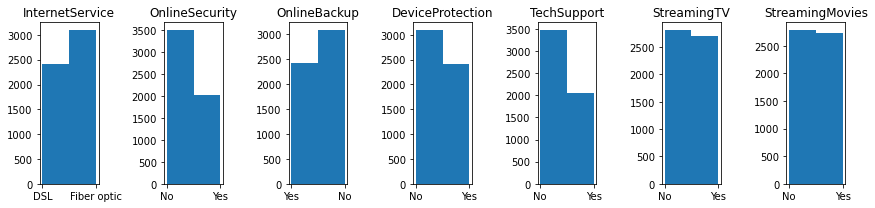




Предварительный просмотр данных в датафрейме personal:



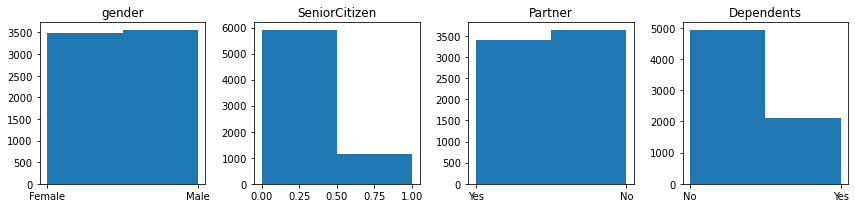




Предварительный просмотр данных в датафрейме phone:



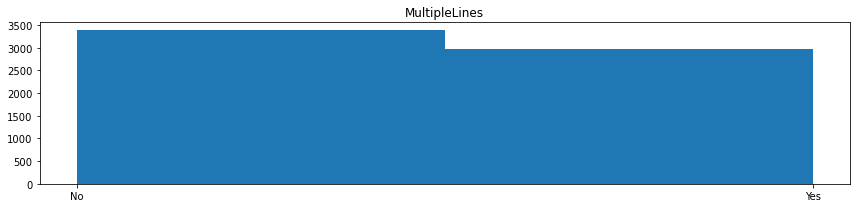

In [9]:
display_histos([internet, personal, phone])

Предварительный просмотр данных в датафрейме "contract":



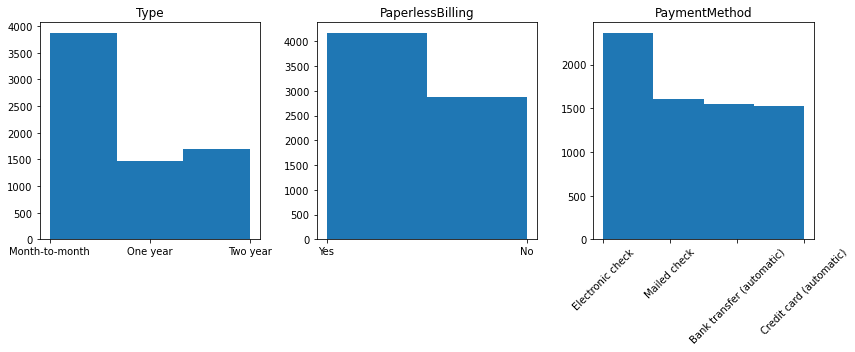

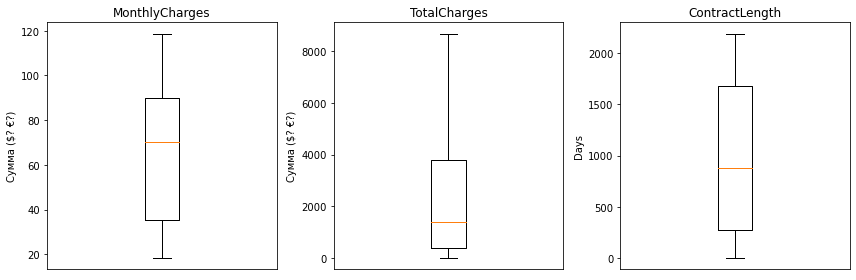

Описание данных в столбце "MonthlyCharges":

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64 

Описание данных в столбце "TotalCharges":

count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64 

Описание данных в столбце "ContractLength":

count    7043.000000
mean      985.996166
std       747.587844
min         0.000000
25%       273.000000
50%       883.000000
75%      1676.000000
max      2191.000000
Name: ContractLength, dtype: float64 



In [10]:
print(f'Предварительный просмотр данных в датафрейме "contract":\n')

cols = contract.drop(columns=['customerID', 'BeginDate', 'EndDate', 'MonthlyCharges', 'TotalCharges', 'ContractLength']).columns

fig, ax = plt.subplots(1, (len(cols)), figsize=(12, 5))
for i, col in zip(range(len(cols)), cols):
    ax[i].hist(contract[col], bins=(len(contract[col].unique())))
    plt.xticks(rotation=45)
    ax[i].set_title(col)
plt.tight_layout()
plt.show()


fig2, ax2 = plt.subplots(1, 3, figsize=(12, 4))

ax2[0].boxplot(contract['MonthlyCharges'])
ax2[0].set_ylabel('Сумма ($? €?)')
ax2[0].set_xticks([])
ax2[0].set_title('MonthlyCharges')


ax2[1].boxplot(contract['TotalCharges'])
ax2[1].set_ylabel('Сумма ($? €?)')
ax2[1].set_xticks([])
ax2[1].set_title('TotalCharges')


ax2[2].boxplot(contract['ContractLength'])
ax2[2].set_ylabel('Days')
ax2[2].ticklabel_format(axis='y', style='plain')
ax2[2].set_xticks([])
ax2[2].set_title('ContractLength')

plt.tight_layout()
plt.show()

print('Описание данных в столбце "MonthlyCharges":\n')
print(contract['MonthlyCharges'].describe(), '\n')


print('Описание данных в столбце "TotalCharges":\n')
print(contract['TotalCharges'].describe(), '\n')


print('Описание данных в столбце "ContractLength":\n')
print(contract['ContractLength'].describe(), '\n')

##### Визуализация данных: выводы

Графики помогли понять, что данные достаточно балансированные. Однако, некоторые признаки заметно отличаются от этой тенденции.

- Вид интернет связи: у большинства людей волоконно-оптическая связь
- Дополнительные услуги: как правило, у людей нет допольнительных услуг (`'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport'`)
- Возраст клиентов: подавляющее большинство клиентов *не* являются людьми пожилого возраста
- Наличие детей: у большинства клиентов нет подопечных
- Тип контракта: у большинства клиентов помесячный контракт
- Тип оплаты: большинство клиентов платит электронным способом ('Electronic check', 'Bank transfer (automatic)', 'Credit card (automatic)')


### Поиск особенностей данных и соотношений между данными
<a id='другое_исследование'></a>

[Содержание](#содержание)

In [11]:
# display(contract['TotalCharges'].sort_values().to_frame())
contract['TotalCharges'] = [0 if i == ' ' else float(i) for i in contract['TotalCharges']]
display(contract['TotalCharges'].sort_values().to_frame())
print(f'Количество контрактов без какой-либо оплаты: {len(contract.query("TotalCharges == 0"))}')
print('Информации по контрактам без оплаты:')
display(contract.query('TotalCharges == 0'))

,TotalCharges
3826,0.00
5218,0.00
4380,0.00
753,0.00
488,0.00
...,...
2187,8564.75
5347,8594.40
6768,8670.10
4586,8672.45


Количество контрактов без какой-либо оплаты: 11
Информации по контрактам без оплаты:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractLength
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0.0,0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0.0,0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0.0,0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0.0,0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0.0,0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,0.0,0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0.0,0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0.0,0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,0.0,0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,0.0,0


*Создание единой таблицы*

In [12]:
# df_all = contract.merge(internet, on='customerID').merge(personal, on='customerID').merge(phone, how='outer', on='customerID')
# df_all.columns
# df_all.head()
df_all = contract.merge(internet, how='outer', on='customerID').merge(personal, on='customerID').merge(phone, how='outer', on='customerID')

df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   ContractLength    7043 non-null   int64  
 9   InternetService   5517 non-null   object 
 10  OnlineSecurity    5517 non-null   object 
 11  OnlineBackup      5517 non-null   object 
 12  DeviceProtection  5517 non-null   object 
 13  TechSupport       5517 non-null   object 
 14  StreamingTV       5517 non-null   object 
 15  StreamingMovies   5517 non-null   object 
 16  gender            7043 non-null   object 


### Замена пропусков

Поскольку не у всех людей есть все услуги, после соединения таблиц полявилось довольно много пропусков. Однако, это не проблема, поскольку пропуски только в столбцах с информацией об услугах, что значит, что у таких клиентов просто нет той или иной услуги.

Чтобы обрабатывать пропуски будет сделано следующее:

- InternetService
    - Нынешные значения: 'DSL', 'Fiber optic', nan
    - Пропуски будут заменены строкой 'No'
    
    
- OnlineSecurity
    - Нынешные значения: 'No', 'Yes', nan
    - Пропуски будут заменены строкой 'No'
    
    
- OnlineBackup
    - Нынешные значения: 'No', 'Yes', nan
    - Пропуски будут заменены строкой 'No'
    
    
- DeviceProtection
    - Нынешные значения: 'No', 'Yes', nan
    - Пропуски будут заменены строкой 'No'
    
    
- TechSupport
    - Нынешные значения: 'No', 'Yes', nan
    - Пропуски будут заменены строкой 'No'
    
    
- StreamingTV
    - Нынешные значения: 'No', 'Yes', nan
    - Пропуски будут заменены строкой 'No'
    
    
- StreamingMovies
    - Нынешные значения: 'No', 'Yes', nan
    - Пропуски будут заменены строкой 'No'
    
    
- MultipleLines
    - Нынешные значения: 'No', 'Yes', nan
    - Пропуски будут заменены строкой 'no_phone'


In [13]:
for col in ['InternetService', 'OnlineSecurity', 'OnlineBackup', 
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    df_all[col] = df_all[col].fillna('No')
    
df_all['MultipleLines'] = df_all['MultipleLines'].fillna('no_phone')

In [14]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   ContractLength    7043 non-null   int64  
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  gender            7043 non-null   object 


In [15]:
display(df_all[df_all.isna().any(axis=1)])

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractLength,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines


Все пропуски были успешно обработаны.

*Устранение ненужных столбцов*
- 'customerID'
- 'ContractLength'

In [16]:
cols_to_drop = ['customerID', 'ContractLength']
cols_to_factorize = ['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 
                     'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                     'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines']

df_all = df_all.drop(columns=cols_to_drop)

### Создание новых признаков
<a id='новые_признаки'></a>

Новые признаки будут:

`'single_parent'` : родитель-одиночка 

`'single_mother'` : мать-одиночка

`'single_father'` : отец-одиночка

`'unnecessary_mail'` :
- этот признак показывает людей, которые платят электронно но всё равно получают квитанции по почте

`'streaming_package'` :
- этот признак показывает, когда у человека есть оба услуги стриминг (и фильмы, и телевидение)

*Временные признаки*

В датасете есть информация о точной дате заключения контракта. Я решил разделить эти данные на данные о месяце заключения и о годе заключения контракта. Если бы в датасете были данные о более длинном периоде (здесь только ~8 лет), и к тому же если бы были сравнительно однинаковое количество данных с каждого года, я бы хотел оставить всю эту информацию. Однако, мне кажется, что данных не хватает чтобы создать какую-то подробную картину о временных тенденциях. Поэтому, я решил создать категориальные признаки. Данные о месяце заключения контракта возможно содержат информацию о какой-нибудь сезонности. Из-за дисбаланса в данных о годе заключения контракта, я решил, что лучше считать годы как некие не связанные между собой группы, вместо того, чтобы посмотреть на эти данные в временном порядке.

`'begin_month'` : месяц заключения контракта

`'begin_year'` : год заключения контракта

In [17]:
def single_parent(row):
    if row['Partner'] == 'No' and row['Dependents'] == 'Yes':
        return 1
    else:
        return 0
    

def single_mother(row):
    if row['Partner'] == 'No' and row['Dependents'] == 'Yes' and row['gender'] == 'Female':
        return 1
    else:
        return 0
    
def single_father(row):
    if row['Partner'] == 'No' and row['Dependents'] == 'Yes' and row['gender'] == 'Male':
        return 1
    else:
        return 0

def unnecessary_mail(row):
    if row['PaperlessBilling'] == 'No' and row['PaymentMethod'] != 'Mailed check':
        return 1
    else:
        return 0
    
def streaming_package(row):
    if row['StreamingMovies'] == 'Yes' and row['StreamingTV'] == 'Yes':
        return 1
    else:
        return 0
    
def begin_year(row):
    return pd.to_datetime(row['BeginDate'], infer_datetime_format=True).year

def begin_month(row):
    return pd.to_datetime(row['BeginDate'], infer_datetime_format=True).month

In [18]:
df_all['single_parent'] = df_all.apply(single_parent, axis=1)
df_all['single_mother'] = df_all.apply(single_mother, axis=1)
df_all['single_father'] = df_all.apply(single_father, axis=1)
df_all['unnecessary_mail'] = df_all.apply(unnecessary_mail, axis=1)
df_all['streaming_package'] = df_all.apply(streaming_package, axis=1)
df_all['begin_year'] = df_all.apply(begin_year, axis=1)
df_all['begin_month'] = df_all.apply(begin_month, axis=1)

*Устранение дубликатов*

In [19]:
print(f'Количество дубликатов в датафрейме df_all: {len(df_all[df_all.duplicated() == True])}')
# df_all[df_all.duplicated() == True]
df_all = df_all.drop_duplicates()

Количество дубликатов в датафрейме df_all: 13


In [20]:
print('Проверка за дубликаты после попытки их устранения:')
print(f'Новое количество дубликатов: {len(df_all[df_all.duplicated() == True])}')

Проверка за дубликаты после попытки их устранения:
Новое количество дубликатов: 0


In [21]:
display(df_all.head().T)

df_all.info()

,0,1,2,3,4
BeginDate,2020-01-01,2017-04-01,2019-10-01,2016-05-01,2019-09-01
EndDate,No,No,2019-12-01 00:00:00,No,2019-11-01 00:00:00
Type,Month-to-month,One year,Month-to-month,One year,Month-to-month
PaperlessBilling,Yes,No,Yes,No,Yes
PaymentMethod,Electronic check,Mailed check,Mailed check,Bank transfer (automatic),Electronic check
MonthlyCharges,29.85,56.95,53.85,42.3,70.7
TotalCharges,29.85,1889.5,108.15,1840.75,151.65
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No
OnlineBackup,Yes,No,Yes,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7030 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   BeginDate          7030 non-null   object 
 1   EndDate            7030 non-null   object 
 2   Type               7030 non-null   object 
 3   PaperlessBilling   7030 non-null   object 
 4   PaymentMethod      7030 non-null   object 
 5   MonthlyCharges     7030 non-null   float64
 6   TotalCharges       7030 non-null   float64
 7   InternetService    7030 non-null   object 
 8   OnlineSecurity     7030 non-null   object 
 9   OnlineBackup       7030 non-null   object 
 10  DeviceProtection   7030 non-null   object 
 11  TechSupport        7030 non-null   object 
 12  StreamingTV        7030 non-null   object 
 13  StreamingMovies    7030 non-null   object 
 14  gender             7030 non-null   object 
 15  SeniorCitizen      7030 non-null   int64  
 16  Partner            7030 

*Перевод данных типа `object` на тип `int64`*

In [22]:
cols_to_factorize = ['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 
                     'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                     'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines']

df_all_factorized = df_all.copy(deep=False)
df_all_factorized[cols_to_factorize] = df_all_factorized[cols_to_factorize].apply(lambda x: pd.factorize(x)[0])
df_all_factorized['EndDate'] = [0 if i == 'No' else 1 for i in df_all_factorized['EndDate']]


In [23]:
display(df_all_factorized.head().T)

df_all_factorized.info()

,0,1,2,3,4
BeginDate,2020-01-01,2017-04-01,2019-10-01,2016-05-01,2019-09-01
EndDate,0,0,1,0,1
Type,0,1,0,1,0
PaperlessBilling,0,1,0,1,0
PaymentMethod,0,1,1,2,0
MonthlyCharges,29.85,56.95,53.85,42.3,70.7
TotalCharges,29.85,1889.5,108.15,1840.75,151.65
InternetService,0,0,0,0,1
OnlineSecurity,0,1,1,1,0
OnlineBackup,0,1,0,1,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7030 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   BeginDate          7030 non-null   object 
 1   EndDate            7030 non-null   int64  
 2   Type               7030 non-null   int64  
 3   PaperlessBilling   7030 non-null   int64  
 4   PaymentMethod      7030 non-null   int64  
 5   MonthlyCharges     7030 non-null   float64
 6   TotalCharges       7030 non-null   float64
 7   InternetService    7030 non-null   int64  
 8   OnlineSecurity     7030 non-null   int64  
 9   OnlineBackup       7030 non-null   int64  
 10  DeviceProtection   7030 non-null   int64  
 11  TechSupport        7030 non-null   int64  
 12  StreamingTV        7030 non-null   int64  
 13  StreamingMovies    7030 non-null   int64  
 14  gender             7030 non-null   int64  
 15  SeniorCitizen      7030 non-null   int64  
 16  Partner            7030 

##### Обработка данных: итоги

Успешно совершены следующие шаги:

- создание новых признаков
    - `'single_parent'`
    - `'single_mother'`
    - `'single_father'`
    - `'unnecessary_mail'`
    - `'streaming_package'`
    - `'begin_year'`
    - `'begin_month'`
    
- Устранение дубликатов

- Перевод данных типа `object` на числовой тип `int64`


*Просмотр на год заключения контрактов*

,BeginDate
2019,1957
2014,1344
2018,1030
2015,852
2017,845
2016,763
2020,244
2013,8



Количество новых контрактов:


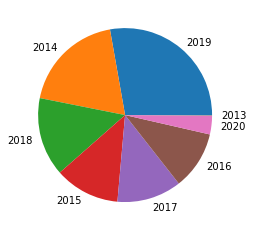

In [24]:
contract_starts = pd.to_datetime(contract['BeginDate'], infer_datetime_format=True)
contract_starts = contract_starts.apply(lambda x: x.year)
display(contract_starts.value_counts().to_frame())
print('\nКоличество новых контрактов:')
plt.pie(contract_starts.value_counts(), labels=contract_starts.value_counts().index)
plt.show()

In [25]:
contract_internet = contract.merge(internet, on='customerID')
contract_phone = contract.merge(phone, on='customerID')
internet_phone = internet.merge(phone, on='customerID', how='inner')
# internet[~(contract['customerID'].isin(contract_internet['customerID']))].info()
no_internet_ids = internet[~(contract['customerID'].isin(contract_internet['customerID']))]['customerID'].unique()
no_phone_ids = phone[~(contract['customerID'].isin(contract_phone['customerID']))]['customerID'].unique()

*Сравнение данных об уходах людей с интернет услугами и людей с услугами телефонии*

In [26]:
phone_ends = phone.merge(contract[['customerID', 'EndDate']], on='customerID')
print("Информация об уходах клиентов с услагами телефонии:")
display(phone_ends.query('EndDate != "No"').sort_values('EndDate'))


print("\nИнформация об уходах клиентов с услугами телефонии и интерет-услугами:")

display(phone_ends[(phone['customerID'].isin(internet['customerID'])) & (phone_ends['EndDate'] != 'No')])
                                                                          
                                                                          

Информация об уходах клиентов с услагами телефонии:


,customerID,MultipleLines,EndDate
3221,2219-MVUSO,No,2019-10-01 00:00:00
4128,0318-QUUOB,No,2019-10-01 00:00:00
4130,5520-FVEWJ,Yes,2019-10-01 00:00:00
1498,9490-DFPMD,Yes,2019-10-01 00:00:00
1492,4690-LLKUA,No,2019-10-01 00:00:00
...,...,...,...
2426,2725-KXXWT,No,2020-01-01 00:00:00
3782,3663-MITLP,No,2020-01-01 00:00:00
5305,4581-SSPWD,Yes,2020-01-01 00:00:00
749,3643-AHCFP,Yes,2020-01-01 00:00:00



Информация об уходах клиентов с услугами телефонии и интерет-услугами:


,customerID,MultipleLines,EndDate
1,3668-QPYBK,No,2019-12-01 00:00:00
2,9237-HQITU,No,2019-11-01 00:00:00
3,9305-CDSKC,Yes,2019-11-01 00:00:00
5,7892-POOKP,Yes,2019-11-01 00:00:00
10,0280-XJGEX,Yes,2019-10-01 00:00:00
...,...,...,...
6342,1699-HPSBG,No,2019-11-01 00:00:00
6347,8775-CEBBJ,No,2019-11-01 00:00:00
6352,6894-LFHLY,Yes,2019-11-01 00:00:00
6354,0639-TSIQW,Yes,2019-10-01 00:00:00


#### Отмечания
<a id='отмечания'></a>

Стоит делать некоторые отмечания:

- сравнительно мало данных с 2013 и 2020 годов
- Посмотрив на `.corr` всех данных, видно, что нету определённого признака, который явно влияет сильнее на `'EndDate'` чем другие. Есть некоторые признаки, которые меньше влияют (`['MultipleLines', 'gender', 'MonthlyCharges']`), но в целом без алгоритмов нельзя делать выводы
- Больше помесячных контрактов чем контракты на год или на два года вместе взяты
- Очень мало (113) расторжений контракта у людей, у которых были исключительно услуги телефонии. Возможно стоит исключить эти данные и сосредоточиться на данные об интенет-услугах.


*Создание таблицы с факторизированными данными чтобы посмотреть на корреляцию с целевым признаком `'EndDate'`*

In [28]:
display(df_all_factorized.corr().sort_values(by='EndDate'))

,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,...,Partner,Dependents,MultipleLines,single_parent,single_mother,single_father,unnecessary_mail,streaming_package,begin_year,begin_month
Type,-0.397421,1.000000,0.177933,0.358603,-0.076262,0.446023,0.101993,0.244805,-0.154146,0.218445,...,-0.293766,0.242435,0.082640,-0.020651,-0.024367,-0.006344,0.156146,0.161037,-0.648381,-0.202010
PaymentMethod,-0.262734,0.358603,0.101709,1.000000,-0.075090,0.221908,0.008855,0.162988,-0.096072,0.110775,...,-0.132532,0.123429,0.025306,0.014432,0.012282,0.008343,0.195519,0.002488,-0.325270,-0.106391
TotalCharges,-0.198829,0.446023,-0.157823,0.221908,0.650619,1.000000,-0.173801,0.411014,-0.508605,0.521381,...,-0.316290,0.060956,0.411648,-0.096651,-0.065239,-0.069883,0.006963,0.537318,-0.819254,-0.196503
PaperlessBilling,-0.190758,0.177933,1.000000,0.101709,-0.351172,-0.157823,0.137075,0.004321,0.126162,-0.103188,...,-0.015943,0.112248,-0.132894,0.043263,0.016190,0.041997,0.738446,-0.189824,0.017190,-0.021544
OnlineSecurity,-0.171527,0.244805,0.004321,0.162988,0.295771,0.411014,-0.392330,1.000000,-0.283225,0.274825,...,-0.142149,0.080267,0.032071,-0.009513,-0.001424,-0.010994,0.061237,0.153213,-0.315487,-0.105232
TechSupport,-0.164968,0.293008,-0.037251,0.167323,0.337558,0.431265,-0.388681,0.354447,-0.293629,0.332744,...,-0.119004,0.062543,0.032372,-0.014139,0.004057,-0.021424,0.035819,0.266251,-0.313833,-0.096933
Dependents,-0.164520,0.242435,0.112248,0.123429,-0.115626,0.060956,0.046289,0.080267,-0.022814,0.013098,...,-0.452077,1.000000,-0.020281,0.355275,0.221602,0.271874,0.064774,-0.018939,-0.146582,-0.069230
unnecessary_mail,-0.121958,0.156146,0.738446,0.195519,-0.113407,0.006963,0.000835,0.061237,0.016133,0.009340,...,-0.054847,0.064774,-0.034701,-0.002011,-0.005662,0.002092,1.000000,-0.069854,-0.111695,-0.051162
DeviceProtection,-0.066353,0.218445,-0.103188,0.110775,0.482109,0.521381,-0.305746,0.274825,-0.302869,1.000000,...,-0.152698,0.013098,0.121193,-0.062892,-0.027286,-0.057963,0.009340,0.392167,-0.356333,-0.094008
InternetService,-0.046554,0.101993,0.137075,0.008855,-0.320861,-0.173801,1.000000,-0.392330,0.313694,-0.305746,...,-0.003258,0.046289,0.188450,0.010951,-0.004498,0.017711,0.000835,-0.164055,0.031099,-0.003455


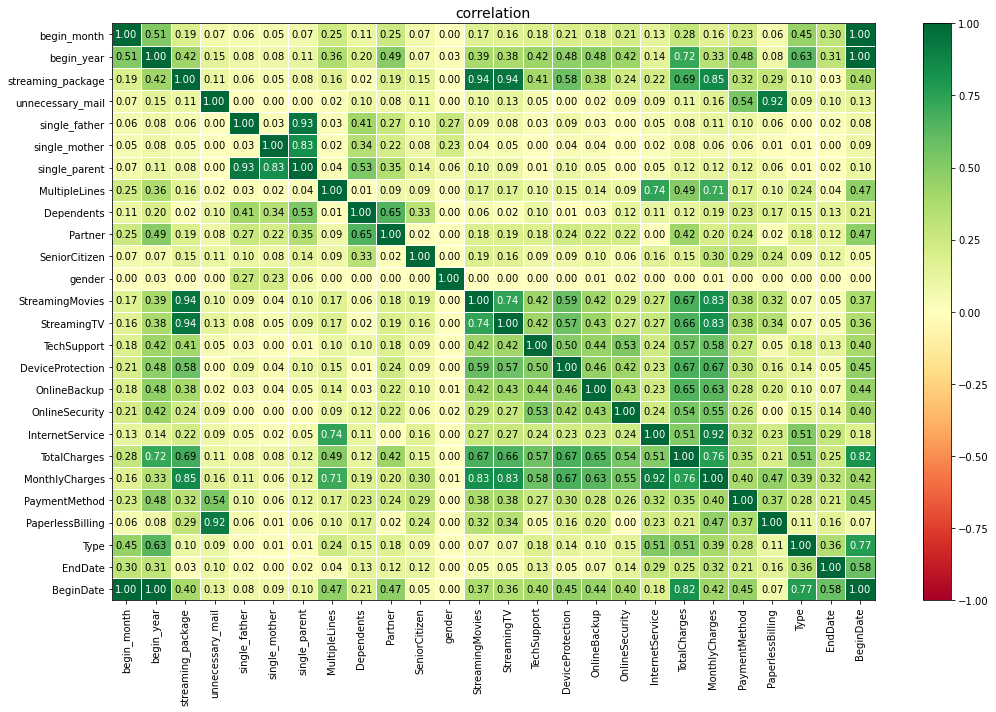

,EndDate
EndDate,1.000000
BeginDate,0.582165
Type,0.358045
MonthlyCharges,0.318927
begin_year,0.309330
begin_month,0.299707
InternetService,0.288039
TotalCharges,0.249138
PaymentMethod,0.211740
PaperlessBilling,0.155947


In [29]:
phik_mtrx = phik_matrix(df_all, interval_cols=['MonthlyCharges', 'TotalCharges'])


plot_correlation_matrix(matrix_colors=phik_mtrx.values, x_labels=phik_mtrx.columns, 
                        y_labels=phik_mtrx.index, figsize=(15,10))
plt.tight_layout()
plt.show()

display(phik_mtrx['EndDate'].to_frame().sort_values('EndDate', ascending=False))

###### Корреляция: замечания

Не у одного признака нет высокой корреляции с целевым признаком. Это означает, что нету одного определённого фактора, который больше всего влияет на уход клиентов. Наоборот, это значит, что наша модель должна найти то, как сочетание разных факторов влияет на уход клиента.




*Мультиколлинеарность*

In [30]:
def display_vif(cols_to_drop):
    mc_df = df_all_factorized.drop(columns=cols_to_drop)
    vif_df = pd.DataFrame()
    vif_df['feature'] = mc_df.columns
    vif_df['vif'] = [vif(mc_df.values, i) for i in range(mc_df.shape[1])]
    display(vif_df.sort_values('vif', ascending=False))
    high_vif = vif_df[vif_df["vif"] >= 10]["feature"].values
    med_vif = vif_df[(vif_df["vif"] >= 5) & (vif_df["vif"] <= 10)]["feature"].values
    if len(high_vif) != 0:
        print(f'Признаки с VIF ≥ 10: {high_vif}')
        print(f'Стоит перепроверить VIF, без признака/ов: {high_vif}')
    elif len(med_vif) != 0:
        print(f'Признаки с VIF между 5 и 10: {med_vif}')
        print(f'Возможно стоит перепроверить VIF, без признака/ов: {med_vif}')
    else:
        print('Нету признаков с VIF выше 10')

In [31]:
display_vif(['BeginDate', 'EndDate'])

,feature,vif
19,single_father,inf
18,single_mother,inf
17,single_parent,inf
22,begin_year,32.744558
3,MonthlyCharges,31.011831
16,MultipleLines,9.750810
4,TotalCharges,7.930938
21,streaming_package,7.020158
10,StreamingTV,5.624187
11,StreamingMovies,5.537084


Признаки с VIF ≥ 10: ['MonthlyCharges' 'single_parent' 'single_mother' 'single_father'
 'begin_year']
Стоит перепроверить VIF, без признака/ов: ['MonthlyCharges' 'single_parent' 'single_mother' 'single_father'
 'begin_year']


In [32]:
display_vif(['BeginDate', 'EndDate', 'MonthlyCharges', 'begin_year', 'single_parent'])

,feature,vif
3,TotalCharges,7.159233
19,streaming_package,6.781920
15,MultipleLines,6.574851
9,StreamingTV,4.799009
10,StreamingMovies,4.752607
1,PaperlessBilling,4.335697
4,InternetService,4.073201
20,begin_month,3.743572
6,OnlineBackup,3.650471
18,unnecessary_mail,3.315552


Признаки с VIF между 5 и 10: ['TotalCharges' 'MultipleLines' 'streaming_package']
Возможно стоит перепроверить VIF, без признака/ов: ['TotalCharges' 'MultipleLines' 'streaming_package']


In [33]:
display_vif(['BeginDate', 'EndDate', 'MonthlyCharges', 'begin_year', 'single_parent', 'TotalCharges', 'streaming_package'])


,feature,vif
14,MultipleLines,5.343749
1,PaperlessBilling,4.296699
3,InternetService,3.967774
18,begin_month,3.702969
17,unnecessary_mail,3.302851
5,OnlineBackup,3.229011
12,Partner,2.995280
2,PaymentMethod,2.683977
0,Type,2.635581
9,StreamingMovies,2.526025


Признаки с VIF между 5 и 10: ['MultipleLines']
Возможно стоит перепроверить VIF, без признака/ов: ['MultipleLines']


PhiK тест и проверка мультиколлинеарности проведены.

PhiK использует другой алгоритм чем метод `.corr`, поэтому сами результаты конечно отличаются, однако выводы скорее похожие. Нету признаков, которые очень сильно влияют на `'EndDate'`. Однако, PhiK показал более тесная связь между `'BeginDate'` и `'EndDate'`, чем показала корреляция Пирсона.
    
Проверка мультиколлинеарности показала более интересную информацию. Проверялась мультиколлинеарность несколько раз, каждый раз удаляя по одному признаку (не показана каждая проверка). Мультиколлинеарность плоха тем, что она может скрывать влияние определённых признаков. Если суть проекта была в том, чтобы определить влияния разных факторов, тогда приходилось бы больше развивать эту часть проекта. Однако, для этого проекта важны предсказания, а мультиколлинеарность не всегда влияет отрицательно на способность модели предсказывать. Это важно отметить потому, что в итоге я решил не устранять все признаки с высокой мультиколлинеарностью. Конкретнее, я говорю о признаке `'TotalCharges'`. Мне показалось логично, чтобы такая информация осталась в датасете. Поэтому, я запускал остальные части проекта с и без этого признака; результаты показали, что наличие этого признака в датасете положительно влияет на итоговые результаты roc_auc_score. В конце концов, благодаря проверке мультиколлинеарности, я решил устранить следующие признаки:

- `'BeginDate'`
- `'begin_year'`
- `'MonthlyCharges'`
- `'single_parent'`
- `'streaming_package'`


*Устранение признаков со высокой мультилинеарности*

In [34]:
df_all = df_all.drop(columns=['BeginDate', 'begin_year', 'MonthlyCharges', 'single_parent', 'streaming_package'])
df_all_factorized = df_all_factorized.drop(columns=['BeginDate', 'begin_year', 'MonthlyCharges', 'single_parent', 'streaming_package'])


*Перепроверка коррелации*

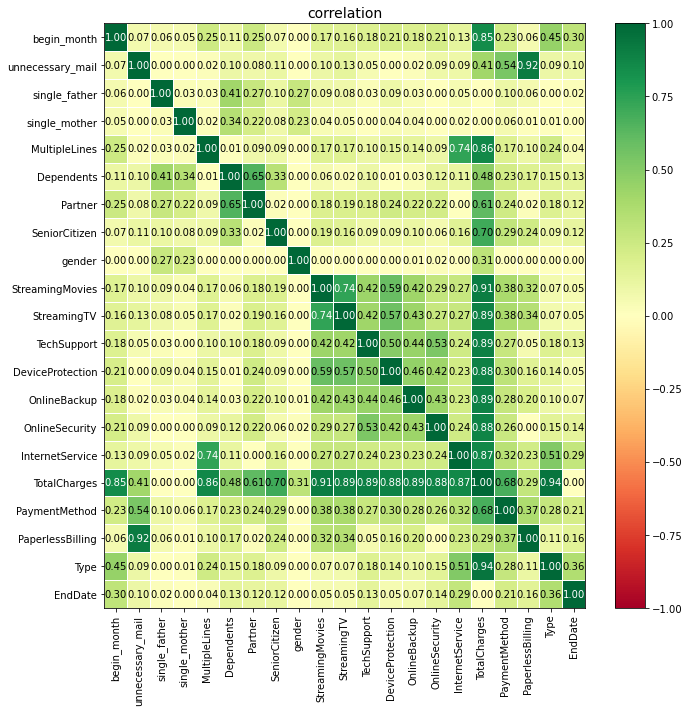

,EndDate
EndDate,1.000000
Type,0.358045
begin_month,0.299707
InternetService,0.288039
PaymentMethod,0.211740
PaperlessBilling,0.155947
OnlineSecurity,0.139622
TechSupport,0.134484
Dependents,0.133661
SeniorCitizen,0.122573


In [35]:
phik_mtrx = phik_matrix(df_all, interval_cols=[])


plot_correlation_matrix(matrix_colors=phik_mtrx.values, x_labels=phik_mtrx.columns, 
                        y_labels=phik_mtrx.index, figsize=(10,10))
plt.tight_layout()
plt.show()

display(phik_mtrx['EndDate'].to_frame().sort_values('EndDate', ascending=False))

In [36]:
corr_series = df_all_factorized.corr()['EndDate']
phik_series = phik_mtrx['EndDate']

comb_df = pd.concat([phik_series, corr_series], axis=1)
comb_df.columns = ['phik_EndDate', 'corr_EndDate']

display(comb_df.sort_values('phik_EndDate', ascending=False))



,phik_EndDate,corr_EndDate
EndDate,1.000000,1.000000
Type,0.358045,-0.397421
begin_month,0.299707,0.179785
InternetService,0.288039,-0.046554
PaymentMethod,0.211740,-0.262734
PaperlessBilling,0.155947,-0.190758
OnlineSecurity,0.139622,-0.171527
TechSupport,0.134484,-0.164968
Dependents,0.133661,-0.164520
SeniorCitizen,0.122573,0.150392


### План действий
<a id='план'></a>

1. Создание новых признаков
    - исследовательский процесс: не обязательно, чтобы все новосозданные признаки были использованы в финальной версии модели
    - варианты:
        - проверка одиночных родителей (`'Partner'` и `'Dependents'`)
        - проверка совмещение электронной оплаты и получения рассылок (`'BillingMethod'` и `'PaperlessBilling'`)
        - другие?
        
        
2. Проверка разных моделей:
    - посмотреть на предварительные результаты разных моделей
        - вероятно:
            - sklearn.linear_model.LogisticRegression
            - sklearn.linear_model.RidgeClassifier
            - sklearn.ensemble.RandomForestClassifier
            - sklearn.ensemble.ExtraTreesClassifier
            - lightgbm.LGBMClassifier
            - catboost.CatBoostClassifier
            - xgboost.XGBClassifier


3. Улучшение результатов лучших моделей
    - Использовать Optuna чтобы найти лучших параметров найобещающих моделей

# Часть 2

### Тестирование разных моделей
<a id='тестирование_моделей'></a>

[Содержание](#содержание)

##### Разделение на тренировочную, тестовую, и валидационную выборки

In [37]:
train_features, valid_test_features, train_target, valid_test_target = (
    train_test_split(df_all_factorized.drop(columns=['EndDate']), df_all_factorized['EndDate'], test_size=0.2, random_state=80822)
)

valid_features, test_features, valid_target, test_target = train_test_split(valid_test_features, valid_test_target, test_size=0.2, random_state=80822)


In [38]:
print(f'Количество данных, которые будут использованы для тренирования и тестирования модели: {len(df_all)}')
print(f'Размер тренировочной выборки: {len(train_features)}')
print(f'Размер тестовой выборки: {len(valid_features)}')
print(f'Размер валидационной выборки: {len(test_features)}')


Количество данных, которые будут использованы для тренирования и тестирования модели: 7030
Размер тренировочной выборки: 5624
Размер тестовой выборки: 1124
Размер валидационной выборки: 282


In [39]:
lin_reg = LogisticRegression()
ridge = RidgeClassifier()
rand_forest = RandomForestClassifier()
extra_trees = ExtraTreesClassifier()
cat_boost = CatBoostClassifier(verbose=False, random_state=80822)
lgb_reg = lgb.LGBMClassifier(random_state=80822)
xgb_reg = xgb.XGBClassifier(random_state=80822)
dummy_reg = DummyClassifier()

models_list = [lin_reg, ridge, rand_forest, extra_trees, cat_boost, lgb_reg, xgb_reg, dummy_reg]
model_names = ['log_reg', 'ridge', 'rand_forest', 'extra_trees', 'cat_boost', 'lgb_class', 'xgb_class', 'dummy_class']

def models_test(train_features, train_target, valid_features, valid_target):
    '''
    Проверяет разные модели на базовых параметрах.
    
    Модели:
    - LogisticRegression
    - RidgeClassifier
    - RandomForestClassifier
    - ExtraTreesClassifier
    - CatBoostClassifier
    - LGBMClassifier
    - XGBClassifier
    - DummyClassifier
    
    Возвращает датафрейм с результатами roc_auc_score
    '''
    
    roc_auc_dict = {'log_reg':[], 'ridge':[], 'rand_forest':[], 'extra_trees':[], 'cat_boost':[], 'lgb_class':[], 'xgb_class':[], 'dummy_class':[]}
    for model, name in zip(models_list, model_names):
        model.fit(train_features, train_target)
        pred = model.predict(valid_features)
        roc_auc = roc_auc_score(valid_target, pred)
        roc_auc_dict[name].append(roc_auc)
    roc_auc_df = pd.DataFrame.from_dict(roc_auc_dict, orient='index')
    roc_auc_df.columns = ['roc_auc_score']
    display(roc_auc_df.sort_values('roc_auc_score', ascending=False))

In [40]:
models_test(train_features, train_target, valid_features, valid_target)

[12:39:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,roc_auc_score
xgb_class,0.773131
cat_boost,0.771927
lgb_class,0.770091
rand_forest,0.741377
extra_trees,0.703069
log_reg,0.670505
ridge,0.646500
dummy_class,0.500000


##### Тестирование разных моделей: выводы

*Подход*

Для тестирования разных моделей, я использовал только тренировочную и валидационную выборки (без тестовой). Это логичный подход, поскольку одна из важных причин, по которой тестовая выборка требуется, это для того, чтобы проверить модель после использования валидационной выборки для улулчшения параметров. Поскольку параметры здесь используемые – параметры по умолчанию, не требуется допольнительная проверка с помощью тестовой выборки.

*Результаты*

Есть значительная разница между roc_auc_score результатами моделей, которые используют градиентный бустинг, и результатами моделей без бустнга.

Среди группы с бустнгом, у LGBMClassifier лучший результат (0.812). Однако, все результаты всех три моделей – LGBMClassifier, XGBClassifier, и CatBoostClassifier – похожи; они все около 0.81. В моём опыте, CatBoostClassifier работает медленее чем два остальных, а к тому же, у него худший результат из этих трёх. Поэтому, я попробую улучшить результаты LGBMClassifier и XGBClassifier чтобы найти лучшую модель.

### Улучшение лучших моделей
Лучшие модели: XGBClassifier, LGBMClassifier
<a id='улучшение_модели'></a>

[Содержание](#содержание)

In [63]:
xgb_lgb_cat_results_dict = {'xgb':[], 'lgb':[], 'cat':[]}

def xgb_lgb_cat_tests(train_features, train_target, valid_features, valid_target):
        
        
        def objective_xgb(trial):

            params = {
             'n_estimators' : trial.suggest_int('n_estimators', 5, 300),
             'max_depth' : trial.suggest_int('max_depth', 2, 16),
             'max_leaves' : trial.suggest_int('max_leaves', 30, 100),
             'learning_rate' : trial.suggest_float('learning_rate', 0.1, 1),
             'reg_alpha' : trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
             'reg_lambda' : trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
             'verbosity' : 0,
             'booster' : 'gbtree'
            }

            xgb_mod = xgb.XGBClassifier(**params, random_state=80822)
            xgb_mod.fit(train_features, train_target)
            pred = xgb_mod.predict_proba(valid_features)[:, 1]
            roc_auc = roc_auc_score(valid_target, pred)
            return roc_auc
        
        study_xgb = optuna.create_study(direction='maximize')
        study_xgb.optimize(objective_xgb, n_trials=50)
        print('XGBClassifier результаты: \n')
        print("Number of finished trials: {}".format(len(study_xgb.trials)))
        print("Best trial:")
        trial_xgb = study_xgb.best_trial
        print("  Value: {}".format(trial_xgb.value))
        print("  Params: ")
        for key, value in trial_xgb.params.items():
            print("    {}: {}".format(key, value))
        display(optuna.importance.get_param_importances(study_xgb))
        

        
        best_xgb = xgb.XGBClassifier(**trial_xgb.params, random_state=80822)
        best_xgb.fit(train_features, train_target)
        pred_valid = best_xgb.predict_proba(valid_features)[:, 1]
        roc_auc_valid = roc_auc_score(valid_target, pred_valid)
        pred_test = best_xgb.predict_proba(test_features)[:, 1]
        roc_auc_test = roc_auc_score(test_target, pred_test)
        
        assert trial_xgb.value == roc_auc_valid
        
        xgb_lgb_cat_results_dict['xgb'].append(roc_auc_valid)
        xgb_lgb_cat_results_dict['xgb'].append(roc_auc_test)
        
        
        
        def objective_lgb(trial):

            params = {
             'n_estimators' : trial.suggest_int('n_estimators', 5, 300),
             'max_depth' : trial.suggest_int('max_depth', 2, 16),
             'num_leaves' : trial.suggest_int('num_leaves', 30, 100),
             'learning_rate' : trial.suggest_float('learning_rate', 0.1, 1),
             'reg_alpha' : trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
             'reg_lambda' : trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
             'min_child_samples' : trial.suggest_int('min_child_samples', 3, 20),
             'verbosity' : -1,
             'boosting_type' : 'gbdt'
            }

            lgb_mod = lgb.LGBMClassifier(**params, random_state=80822)
            lgb_mod.fit(train_features, train_target)
            pred = lgb_mod.predict_proba(valid_features)[:, 1]
            roc_auc = roc_auc_score(valid_target, pred)
            return roc_auc
        study_lgb = optuna.create_study(direction='maximize')
        study_lgb.optimize(objective_lgb, n_trials=50)
        print('LGBMClassifier результаты: \n')
        print("Number of finished trials: {}".format(len(study_lgb.trials)))
        print("Best trial:")
        trial_lgb = study_lgb.best_trial

        print("  Value: {}".format(trial_lgb.value))
        print("  Params: ")
        for key, value in trial_lgb.params.items():
            print("    {}: {}".format(key, value))
        display(optuna.importance.get_param_importances(study_lgb))
        
        
        best_lgb = lgb.LGBMClassifier(**trial_lgb.params, random_state=80822)
        best_lgb.fit(train_features, train_target)
        pred_valid = best_lgb.predict_proba(valid_features)[:, 1]
        roc_auc_valid = roc_auc_score(valid_target, pred_valid)
        pred_test = best_lgb.predict_proba(test_features)[:, 1]
        roc_auc_test = roc_auc_score(test_target, pred_test)
        
        assert trial_lgb.value == roc_auc_valid
        
        xgb_lgb_cat_results_dict['lgb'].append(roc_auc_valid)
        xgb_lgb_cat_results_dict['lgb'].append(roc_auc_test)
        
        
        def objective_cat(trial):

            params = {
             'objective': trial.suggest_categorical('objective', ['Logloss', 'CrossEntropy']),
             'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1),
             'depth': trial.suggest_int('depth', 2, 12),
             'learning_rate' : trial.suggest_float('learning_rate', 0.03, 1),
             'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
             'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 20),
             'verbose' : 0,
             'boosting_type': 'Plain'
            }
        
            cat_mod = CatBoostClassifier(**params, random_state=80822)
            cat_mod.fit(train_features, train_target)
            pred = cat_mod.predict_proba(valid_features)[:, 1]
            roc_auc = roc_auc_score(valid_target, pred)
            return roc_auc
        study_cat = optuna.create_study(direction='maximize')
        study_cat.optimize(objective_cat, n_trials=25)
        print('CatBoostClassifier результаты: \n')
        print("Number of finished trials: {}".format(len(study_cat.trials)))
        print("Best trial:")
        trial_cat = study_cat.best_trial

        print("  Value: {}".format(trial_cat.value))
        print("  Params: ")
        for key, value in trial_cat.params.items():
            print("    {}: {}".format(key, value))
        display(optuna.importance.get_param_importances(study_cat))
        
        
        best_cat = CatBoostClassifier(**trial_cat.params, random_state=80822)
        best_cat.fit(train_features, train_target)
        pred_valid = best_cat.predict_proba(valid_features)[:, 1]
        roc_auc_valid = roc_auc_score(valid_target, pred_valid)
        pred_test = best_cat.predict_proba(test_features)[:, 1]
        roc_auc_test = roc_auc_score(test_target, pred_test)
        
        assert trial_cat.value == roc_auc_valid
        
        xgb_lgb_cat_results_dict['cat'].append(roc_auc_valid)
        xgb_lgb_cat_results_dict['cat'].append(roc_auc_test)

In [64]:
# %%time
xgb_lgb_cat_tests(train_features, train_target, valid_features, valid_target)

[I 2022-08-19 12:56:22,473] A new study created in memory with name: no-name-7501c968-ef66-4947-b0a3-ca4cf9866aaa
[I 2022-08-19 12:56:23,524] Trial 0 finished with value: 0.8705082150873737 and parameters: {'n_estimators': 218, 'max_depth': 3, 'max_leaves': 99, 'learning_rate': 0.5419794804619711, 'reg_alpha': 1.712670617137605, 'reg_lambda': 0.00017282915019068554}. Best is trial 0 with value: 0.8705082150873737.
[I 2022-08-19 12:56:23,967] Trial 1 finished with value: 0.8790402640948253 and parameters: {'n_estimators': 130, 'max_depth': 12, 'max_leaves': 80, 'learning_rate': 0.4251125474900085, 'reg_alpha': 8.678550615998468, 'reg_lambda': 0.04987378706031039}. Best is trial 1 with value: 0.8790402640948253.
[I 2022-08-19 12:56:24,295] Trial 2 finished with value: 0.8752128028578378 and parameters: {'n_estimators': 15, 'max_depth': 15, 'max_leaves': 32, 'learning_rate': 0.19870790736923852, 'reg_alpha': 0.0016800730558351293, 'reg_lambda': 0.00014848627539277404}. Best is trial 1 wit

[I 2022-08-19 12:56:54,279] Trial 26 finished with value: 0.8810018379787816 and parameters: {'n_estimators': 172, 'max_depth': 11, 'max_leaves': 55, 'learning_rate': 0.29165138889475395, 'reg_alpha': 0.04661262219376885, 'reg_lambda': 0.2354448888444564}. Best is trial 5 with value: 0.8852598886049302.
[I 2022-08-19 12:56:56,524] Trial 27 finished with value: 0.8754400583687838 and parameters: {'n_estimators': 88, 'max_depth': 13, 'max_leaves': 74, 'learning_rate': 0.4110043833000022, 'reg_alpha': 0.0008468936391956719, 'reg_lambda': 0.021999791875494053}. Best is trial 5 with value: 0.8852598886049302.
[I 2022-08-19 12:56:58,444] Trial 28 finished with value: 0.8802722281804807 and parameters: {'n_estimators': 128, 'max_depth': 9, 'max_leaves': 82, 'learning_rate': 0.15968363841622005, 'reg_alpha': 6.764170963046821e-06, 'reg_lambda': 9.546387309401684}. Best is trial 5 with value: 0.8852598886049302.
[I 2022-08-19 12:57:00,231] Trial 29 finished with value: 0.8720950167252083 and pa

XGBClassifier результаты: 

Number of finished trials: 50
Best trial:
  Value: 0.8901977122945233
  Params: 
    n_estimators: 28
    max_depth: 10
    max_leaves: 56
    learning_rate: 0.1943015571395259
    reg_alpha: 0.002204211151816457
    reg_lambda: 3.68734102693126


OrderedDict([('learning_rate', 0.7776910093830486),
             ('max_depth', 0.08503108417427785),
             ('max_leaves', 0.05945157653274359),
             ('n_estimators', 0.05271100053237833),
             ('reg_lambda', 0.016688921784543127),
             ('reg_alpha', 0.00842640759300846)])

[I 2022-08-19 12:57:33,337] A new study created in memory with name: no-name-f8de7b40-1dae-42fc-a387-ce8741d09cdc
[I 2022-08-19 12:57:33,447] Trial 0 finished with value: 0.8685386673258405 and parameters: {'n_estimators': 41, 'max_depth': 8, 'num_leaves': 72, 'learning_rate': 0.7834886074696453, 'reg_alpha': 4.1018839446667497e-07, 'reg_lambda': 0.00011704842040960484, 'min_child_samples': 3}. Best is trial 0 with value: 0.8685386673258405.
[I 2022-08-19 12:57:34,084] Trial 1 finished with value: 0.8852678624825073 and parameters: {'n_estimators': 188, 'max_depth': 11, 'num_leaves': 82, 'learning_rate': 0.2931341230855665, 'reg_alpha': 5.4064390595596065e-05, 'reg_lambda': 5.4206270369347234e-05, 'min_child_samples': 5}. Best is trial 1 with value: 0.8852678624825073.
[I 2022-08-19 12:57:34,374] Trial 2 finished with value: 0.8858060992189587 and parameters: {'n_estimators': 168, 'max_depth': 14, 'num_leaves': 82, 'learning_rate': 0.5501499405469568, 'reg_alpha': 0.15430166702358294, 

[I 2022-08-19 12:57:41,400] Trial 24 finished with value: 0.8867749253445713 and parameters: {'n_estimators': 197, 'max_depth': 15, 'num_leaves': 96, 'learning_rate': 0.1020945805526437, 'reg_alpha': 0.007928972332408047, 'reg_lambda': 5.547366805538411, 'min_child_samples': 18}. Best is trial 22 with value: 0.88889198984128.
[I 2022-08-19 12:57:41,735] Trial 25 finished with value: 0.8946291947579729 and parameters: {'n_estimators': 154, 'max_depth': 14, 'num_leaves': 79, 'learning_rate': 0.24839111521851437, 'reg_alpha': 0.7093293901212752, 'reg_lambda': 0.07793936820696415, 'min_child_samples': 14}. Best is trial 25 with value: 0.8946291947579729.
[I 2022-08-19 12:57:41,950] Trial 26 finished with value: 0.8849927637060988 and parameters: {'n_estimators': 158, 'max_depth': 9, 'num_leaves': 76, 'learning_rate': 0.4792929006541118, 'reg_alpha': 0.4576580691742772, 'reg_lambda': 0.05063881638487515, 'min_child_samples': 13}. Best is trial 25 with value: 0.8946291947579729.
[I 2022-08-1

[I 2022-08-19 12:57:52,912] Trial 48 finished with value: 0.8913997743392647 and parameters: {'n_estimators': 238, 'max_depth': 13, 'num_leaves': 61, 'learning_rate': 0.1419560402643471, 'reg_alpha': 0.0002497755893900507, 'reg_lambda': 4.042717897975408e-08, 'min_child_samples': 6}. Best is trial 25 with value: 0.8946291947579729.
[I 2022-08-19 12:57:53,203] Trial 49 finished with value: 0.8853794967685861 and parameters: {'n_estimators': 237, 'max_depth': 4, 'num_leaves': 61, 'learning_rate': 0.13628856768108802, 'reg_alpha': 0.00017438679508794755, 'reg_lambda': 2.985573151970222e-08, 'min_child_samples': 5}. Best is trial 25 with value: 0.8946291947579729.


LGBMClassifier результаты: 

Number of finished trials: 50
Best trial:
  Value: 0.8946291947579729
  Params: 
    n_estimators: 154
    max_depth: 14
    num_leaves: 79
    learning_rate: 0.24839111521851437
    reg_alpha: 0.7093293901212752
    reg_lambda: 0.07793936820696415
    min_child_samples: 14


OrderedDict([('learning_rate', 0.5556643525711418),
             ('n_estimators', 0.2719383275744585),
             ('max_depth', 0.08392642661898046),
             ('num_leaves', 0.04623640225120655),
             ('min_child_samples', 0.020500341581371533),
             ('reg_alpha', 0.020123710991849883),
             ('reg_lambda', 0.00161043841099126)])

[I 2022-08-19 12:57:54,870] A new study created in memory with name: no-name-72e032d5-b62c-4b61-876d-55eed99a7b96
[I 2022-08-19 12:57:59,506] Trial 0 finished with value: 0.8496166558354828 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.38907681766926827, 'depth': 7, 'learning_rate': 0.47935007178113664, 'l2_leaf_reg': 0.0009791086440573689, 'min_data_in_leaf': 1}. Best is trial 0 with value: 0.8496166558354828.
[I 2022-08-19 12:58:01,774] Trial 1 finished with value: 0.8564502689190213 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.4514294008626595, 'depth': 3, 'learning_rate': 0.34832816301158187, 'l2_leaf_reg': 0.0003146554594603965, 'min_data_in_leaf': 12}. Best is trial 1 with value: 0.8564502689190213.
[I 2022-08-19 12:58:03,763] Trial 2 finished with value: 0.8437080125508833 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.4287072836963213, 'depth': 3, 'learning_rate': 0.918890177726038, 'l2_leaf_reg': 1.810603827506797

CatBoostClassifier результаты: 

Number of finished trials: 25
Best trial:
  Value: 0.8846299522763428
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.7589644942654982
    depth: 4
    learning_rate: 0.05442119599060883
    l2_leaf_reg: 0.01064630322218898
    min_data_in_leaf: 4


OrderedDict([('learning_rate', 0.5541725012790037),
             ('colsample_bylevel', 0.19919024353831039),
             ('depth', 0.15116130000783237),
             ('min_data_in_leaf', 0.04646426220144574),
             ('l2_leaf_reg', 0.041941171831558675),
             ('objective', 0.007070521141849048)])

0:	learn: 0.6575987	total: 2.58ms	remaining: 2.58s
1:	learn: 0.6279593	total: 5.84ms	remaining: 2.91s
2:	learn: 0.6030254	total: 7.96ms	remaining: 2.64s
3:	learn: 0.5848229	total: 13.9ms	remaining: 3.46s
4:	learn: 0.5663109	total: 17.6ms	remaining: 3.49s
5:	learn: 0.5487514	total: 20.6ms	remaining: 3.41s
6:	learn: 0.5338752	total: 23.4ms	remaining: 3.31s
7:	learn: 0.5194234	total: 26.1ms	remaining: 3.23s
8:	learn: 0.5079940	total: 28.9ms	remaining: 3.18s
9:	learn: 0.4970027	total: 31ms	remaining: 3.07s
10:	learn: 0.4855778	total: 34.8ms	remaining: 3.13s
11:	learn: 0.4746490	total: 37.8ms	remaining: 3.11s
12:	learn: 0.4669163	total: 40.7ms	remaining: 3.09s
13:	learn: 0.4588063	total: 43.2ms	remaining: 3.04s
14:	learn: 0.4512840	total: 45.5ms	remaining: 2.99s
15:	learn: 0.4451580	total: 48.4ms	remaining: 2.97s
16:	learn: 0.4414377	total: 51.3ms	remaining: 2.96s
17:	learn: 0.4349583	total: 53.8ms	remaining: 2.93s
18:	learn: 0.4314466	total: 56.6ms	remaining: 2.92s
19:	learn: 0.4273072	tot

192:	learn: 0.3188901	total: 561ms	remaining: 2.35s
193:	learn: 0.3183901	total: 566ms	remaining: 2.35s
194:	learn: 0.3180948	total: 571ms	remaining: 2.36s
195:	learn: 0.3177134	total: 576ms	remaining: 2.36s
196:	learn: 0.3175093	total: 582ms	remaining: 2.37s
197:	learn: 0.3172992	total: 585ms	remaining: 2.37s
198:	learn: 0.3170424	total: 589ms	remaining: 2.37s
199:	learn: 0.3168205	total: 593ms	remaining: 2.37s
200:	learn: 0.3166382	total: 596ms	remaining: 2.37s
201:	learn: 0.3163294	total: 599ms	remaining: 2.37s
202:	learn: 0.3159355	total: 602ms	remaining: 2.36s
203:	learn: 0.3156729	total: 605ms	remaining: 2.36s
204:	learn: 0.3153183	total: 608ms	remaining: 2.36s
205:	learn: 0.3150271	total: 611ms	remaining: 2.35s
206:	learn: 0.3147392	total: 614ms	remaining: 2.35s
207:	learn: 0.3144968	total: 617ms	remaining: 2.35s
208:	learn: 0.3141852	total: 620ms	remaining: 2.35s
209:	learn: 0.3139466	total: 623ms	remaining: 2.34s
210:	learn: 0.3136413	total: 626ms	remaining: 2.34s
211:	learn: 

393:	learn: 0.2792440	total: 1.3s	remaining: 2s
394:	learn: 0.2791111	total: 1.3s	remaining: 1.99s
395:	learn: 0.2789980	total: 1.31s	remaining: 1.99s
396:	learn: 0.2788437	total: 1.31s	remaining: 1.99s
397:	learn: 0.2786984	total: 1.31s	remaining: 1.98s
398:	learn: 0.2785142	total: 1.31s	remaining: 1.98s
399:	learn: 0.2784288	total: 1.32s	remaining: 1.98s
400:	learn: 0.2782404	total: 1.32s	remaining: 1.98s
401:	learn: 0.2781004	total: 1.33s	remaining: 1.98s
402:	learn: 0.2780261	total: 1.33s	remaining: 1.97s
403:	learn: 0.2779169	total: 1.33s	remaining: 1.97s
404:	learn: 0.2777870	total: 1.34s	remaining: 1.97s
405:	learn: 0.2776078	total: 1.34s	remaining: 1.96s
406:	learn: 0.2774904	total: 1.34s	remaining: 1.96s
407:	learn: 0.2772357	total: 1.35s	remaining: 1.95s
408:	learn: 0.2770649	total: 1.35s	remaining: 1.95s
409:	learn: 0.2768922	total: 1.35s	remaining: 1.95s
410:	learn: 0.2767960	total: 1.36s	remaining: 1.94s
411:	learn: 0.2766948	total: 1.36s	remaining: 1.94s
412:	learn: 0.276

573:	learn: 0.2536301	total: 1.85s	remaining: 1.37s
574:	learn: 0.2535294	total: 1.85s	remaining: 1.37s
575:	learn: 0.2534019	total: 1.85s	remaining: 1.36s
576:	learn: 0.2532356	total: 1.86s	remaining: 1.36s
577:	learn: 0.2531751	total: 1.86s	remaining: 1.36s
578:	learn: 0.2530619	total: 1.87s	remaining: 1.36s
579:	learn: 0.2529028	total: 1.87s	remaining: 1.35s
580:	learn: 0.2527775	total: 1.87s	remaining: 1.35s
581:	learn: 0.2526488	total: 1.88s	remaining: 1.35s
582:	learn: 0.2524627	total: 1.88s	remaining: 1.34s
583:	learn: 0.2523142	total: 1.88s	remaining: 1.34s
584:	learn: 0.2522523	total: 1.89s	remaining: 1.34s
585:	learn: 0.2521135	total: 1.89s	remaining: 1.33s
586:	learn: 0.2520303	total: 1.89s	remaining: 1.33s
587:	learn: 0.2518265	total: 1.9s	remaining: 1.33s
588:	learn: 0.2517468	total: 1.9s	remaining: 1.32s
589:	learn: 0.2516577	total: 1.9s	remaining: 1.32s
590:	learn: 0.2515664	total: 1.9s	remaining: 1.32s
591:	learn: 0.2514584	total: 1.91s	remaining: 1.31s
592:	learn: 0.25

741:	learn: 0.2346772	total: 2.4s	remaining: 836ms
742:	learn: 0.2344977	total: 2.41s	remaining: 834ms
743:	learn: 0.2344146	total: 2.42s	remaining: 832ms
744:	learn: 0.2343472	total: 2.42s	remaining: 829ms
745:	learn: 0.2342225	total: 2.43s	remaining: 827ms
746:	learn: 0.2341489	total: 2.43s	remaining: 825ms
747:	learn: 0.2340760	total: 2.44s	remaining: 822ms
748:	learn: 0.2340206	total: 2.44s	remaining: 819ms
749:	learn: 0.2339557	total: 2.45s	remaining: 816ms
750:	learn: 0.2338571	total: 2.45s	remaining: 813ms
751:	learn: 0.2337095	total: 2.46s	remaining: 810ms
752:	learn: 0.2335735	total: 2.46s	remaining: 806ms
753:	learn: 0.2334855	total: 2.46s	remaining: 803ms
754:	learn: 0.2333905	total: 2.46s	remaining: 800ms
755:	learn: 0.2333160	total: 2.47s	remaining: 797ms
756:	learn: 0.2332039	total: 2.47s	remaining: 793ms
757:	learn: 0.2331373	total: 2.47s	remaining: 790ms
758:	learn: 0.2330736	total: 2.48s	remaining: 787ms
759:	learn: 0.2329525	total: 2.48s	remaining: 784ms
760:	learn: 0

902:	learn: 0.2189178	total: 2.95s	remaining: 317ms
903:	learn: 0.2187822	total: 2.95s	remaining: 314ms
904:	learn: 0.2187353	total: 2.96s	remaining: 310ms
905:	learn: 0.2186098	total: 2.96s	remaining: 307ms
906:	learn: 0.2184035	total: 2.96s	remaining: 304ms
907:	learn: 0.2183289	total: 2.97s	remaining: 301ms
908:	learn: 0.2181515	total: 2.97s	remaining: 297ms
909:	learn: 0.2180731	total: 2.98s	remaining: 294ms
910:	learn: 0.2180278	total: 2.98s	remaining: 291ms
911:	learn: 0.2179668	total: 2.98s	remaining: 288ms
912:	learn: 0.2178857	total: 2.98s	remaining: 284ms
913:	learn: 0.2177796	total: 2.99s	remaining: 281ms
914:	learn: 0.2176995	total: 2.99s	remaining: 278ms
915:	learn: 0.2176353	total: 3s	remaining: 275ms
916:	learn: 0.2175658	total: 3s	remaining: 271ms
917:	learn: 0.2175058	total: 3s	remaining: 268ms
918:	learn: 0.2174174	total: 3.01s	remaining: 265ms
919:	learn: 0.2173530	total: 3.01s	remaining: 262ms
920:	learn: 0.2171789	total: 3.01s	remaining: 258ms
921:	learn: 0.2170644

In [65]:
xgb_lgb_cat_results_df = pd.DataFrame.from_dict(xgb_lgb_cat_results_dict, orient='index')
xgb_lgb_cat_results_df.columns = ['valid_roc_auc', 'test_roc_auc']

In [66]:
display(xgb_lgb_cat_results_df.sort_values(by='valid_roc_auc', ascending=False))


,valid_roc_auc,test_roc_auc
lgb,0.894629,0.898389
xgb,0.890198,0.914141
cat,0.884630,0.889190


##### Результаты

Лучший результат по валидационной выборке получился у LGBMClassifier, а у XGBClassifier получился лучший результат по тестовой выборке. CatBoostClassifier выдал средний результат по обеим выбокам. Также, CatBoostClassifier медленее работает. Поэтому, чтобы определить финальную модель, я протестирую модели LGBMClassifier и XGBClassifier ещё один раз.
    


##### Улучшение лучшей LGBMClassifier модели

In [46]:
xgb_lgb_results_dict = {'xgb':[], 'lgb':[]}

In [47]:
def objective_lgb(trial):

    params = {
     'n_estimators' : trial.suggest_int('n_estimators', 5, 300),
     'max_depth' : trial.suggest_int('max_depth', 2, 16),
     'num_leaves' : trial.suggest_int('num_leaves', 30, 100),
     'learning_rate' : trial.suggest_float('learning_rate', 0.1, 1),
     'reg_alpha' : trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
     'reg_lambda' : trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
     'min_child_samples' : trial.suggest_int('min_child_samples', 3, 20),
     'verbosity' : -1,
     'boosting_type' : 'gbdt'
    }

    lgb_mod = lgb.LGBMClassifier(**params, random_state=80822)
    lgb_mod.fit(train_features, train_target)
    pred = lgb_mod.predict_proba(valid_features)[:, 1]
    roc_auc = roc_auc_score(valid_target, pred)
    return roc_auc
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=150)
print("Number of finished trials: {}".format(len(study_lgb.trials)))
print("Best trial:")
trial_lgb = study_lgb.best_trial
print("  Value: {}".format(trial_lgb.value))
print("  Params: ")
for key, value in trial_lgb.params.items():
    print("    {}: {}".format(key, value))
display(optuna.importance.get_param_importances(study_lgb))

best_lgb = lgb.LGBMClassifier(**trial_lgb.params, random_state=80822)
best_lgb.fit(train_features, train_target)
pred_valid = best_lgb.predict_proba(valid_features)[:, 1]
roc_auc_valid = roc_auc_score(valid_target, pred_valid)
pred_test = best_lgb.predict_proba(test_features)[:, 1]
roc_auc_test = roc_auc_score(test_target, pred_test)

assert trial_lgb.value == roc_auc_valid

print(f'roc_auc_score на валидационной выборке: {roc_auc_valid}\n')
print(f'roc_auc_score на тестовой выборке: {roc_auc_test}')

xgb_lgb_results_dict['lgb'].append(roc_auc_valid)
xgb_lgb_results_dict['lgb'].append(roc_auc_test)


[I 2022-08-19 12:44:27,433] A new study created in memory with name: no-name-6c1d286f-6d3f-444c-9e0c-7441caab8b6d
[I 2022-08-19 12:44:27,714] Trial 0 finished with value: 0.8787213089917429 and parameters: {'n_estimators': 280, 'max_depth': 5, 'num_leaves': 53, 'learning_rate': 0.5074844615653253, 'reg_alpha': 0.00017968310429604262, 'reg_lambda': 3.1365592087570526e-07, 'min_child_samples': 4}. Best is trial 0 with value: 0.8787213089917429.
[I 2022-08-19 12:44:27,888] Trial 1 finished with value: 0.5417512229934734 and parameters: {'n_estimators': 261, 'max_depth': 13, 'num_leaves': 69, 'learning_rate': 0.8751075922773993, 'reg_alpha': 1.2863129320727482e-05, 'reg_lambda': 2.2884150770762007e-06, 'min_child_samples': 9}. Best is trial 0 with value: 0.8787213089917429.
[I 2022-08-19 12:44:28,320] Trial 2 finished with value: 0.8844226314593393 and parameters: {'n_estimators': 194, 'max_depth': 9, 'num_leaves': 91, 'learning_rate': 0.5481643106920702, 'reg_alpha': 1.5651149399870093e-0

[I 2022-08-19 12:44:32,860] Trial 24 finished with value: 0.8866931930994064 and parameters: {'n_estimators': 48, 'max_depth': 10, 'num_leaves': 40, 'learning_rate': 0.1029337396009746, 'reg_alpha': 0.015100137442126203, 'reg_lambda': 0.914026470064059, 'min_child_samples': 5}. Best is trial 22 with value: 0.8918981416878307.
[I 2022-08-19 12:44:32,981] Trial 25 finished with value: 0.891487486992612 and parameters: {'n_estimators': 44, 'max_depth': 10, 'num_leaves': 64, 'learning_rate': 0.10565497268052344, 'reg_alpha': 0.01993571257171149, 'reg_lambda': 0.9023617971292675, 'min_child_samples': 8}. Best is trial 22 with value: 0.8918981416878307.
[I 2022-08-19 12:44:33,085] Trial 26 finished with value: 0.8745270493862106 and parameters: {'n_estimators': 60, 'max_depth': 11, 'num_leaves': 62, 'learning_rate': 0.222231148095625, 'reg_alpha': 6.191022581068694, 'reg_lambda': 2.2600847521658434, 'min_child_samples': 11}. Best is trial 22 with value: 0.8918981416878307.
[I 2022-08-19 12:4

[I 2022-08-19 12:44:36,864] Trial 48 finished with value: 0.8691486689604854 and parameters: {'n_estimators': 59, 'max_depth': 6, 'num_leaves': 100, 'learning_rate': 0.7288175147111818, 'reg_alpha': 1.562578787504261e-05, 'reg_lambda': 0.004875373919363718, 'min_child_samples': 4}. Best is trial 42 with value: 0.8936165123056866.
[I 2022-08-19 12:44:36,953] Trial 49 finished with value: 0.8850944306452064 and parameters: {'n_estimators': 22, 'max_depth': 8, 'num_leaves': 70, 'learning_rate': 0.13635481409701378, 'reg_alpha': 4.090564306351193e-06, 'reg_lambda': 0.038316932605774984, 'min_child_samples': 6}. Best is trial 42 with value: 0.8936165123056866.
[I 2022-08-19 12:44:37,083] Trial 50 finished with value: 0.8806270657326598 and parameters: {'n_estimators': 41, 'max_depth': 9, 'num_leaves': 80, 'learning_rate': 0.3141638630860568, 'reg_alpha': 0.000803013955251306, 'reg_lambda': 0.00033863632533769517, 'min_child_samples': 9}. Best is trial 42 with value: 0.8936165123056866.
[I 2

[I 2022-08-19 12:44:40,844] Trial 72 finished with value: 0.8828438036990818 and parameters: {'n_estimators': 75, 'max_depth': 6, 'num_leaves': 88, 'learning_rate': 0.12737633760499786, 'reg_alpha': 5.4340312349612976e-05, 'reg_lambda': 0.06638175262040762, 'min_child_samples': 11}. Best is trial 42 with value: 0.8936165123056866.
[I 2022-08-19 12:44:41,005] Trial 73 finished with value: 0.8898528420893154 and parameters: {'n_estimators': 69, 'max_depth': 8, 'num_leaves': 77, 'learning_rate': 0.18396814017151847, 'reg_alpha': 0.012688726112878279, 'reg_lambda': 0.00015406918383461784, 'min_child_samples': 12}. Best is trial 42 with value: 0.8936165123056866.
[I 2022-08-19 12:44:41,099] Trial 74 finished with value: 0.8790103620539114 and parameters: {'n_estimators': 45, 'max_depth': 5, 'num_leaves': 79, 'learning_rate': 0.15326336375357452, 'reg_alpha': 0.004883974132411993, 'reg_lambda': 0.0006639259793902068, 'min_child_samples': 8}. Best is trial 42 with value: 0.8936165123056866.
[

[I 2022-08-19 12:44:45,802] Trial 96 finished with value: 0.8902375816824083 and parameters: {'n_estimators': 45, 'max_depth': 9, 'num_leaves': 63, 'learning_rate': 0.11431447641383952, 'reg_alpha': 0.03582163776355035, 'reg_lambda': 2.4667210562350323, 'min_child_samples': 4}. Best is trial 42 with value: 0.8936165123056866.
[I 2022-08-19 12:44:45,939] Trial 97 finished with value: 0.8935008910808193 and parameters: {'n_estimators': 46, 'max_depth': 9, 'num_leaves': 63, 'learning_rate': 0.12173497131756658, 'reg_alpha': 0.018761039070503617, 'reg_lambda': 2.29102981302062, 'min_child_samples': 4}. Best is trial 42 with value: 0.8936165123056866.
[I 2022-08-19 12:44:46,074] Trial 98 finished with value: 0.8911525841343759 and parameters: {'n_estimators': 46, 'max_depth': 9, 'num_leaves': 62, 'learning_rate': 0.11499890142701415, 'reg_alpha': 0.01798306196321424, 'reg_lambda': 1.8789046808958738, 'min_child_samples': 4}. Best is trial 42 with value: 0.8936165123056866.
[I 2022-08-19 12:

[I 2022-08-19 12:44:49,999] Trial 120 finished with value: 0.8902355882130143 and parameters: {'n_estimators': 85, 'max_depth': 7, 'num_leaves': 64, 'learning_rate': 0.1215025405934201, 'reg_alpha': 0.00029713605655068935, 'reg_lambda': 0.05827296965036033, 'min_child_samples': 3}. Best is trial 112 with value: 0.8956538380266247.
[I 2022-08-19 12:44:50,170] Trial 121 finished with value: 0.8916788600544616 and parameters: {'n_estimators': 75, 'max_depth': 9, 'num_leaves': 68, 'learning_rate': 0.14757544468905898, 'reg_alpha': 0.0007486415897808497, 'reg_lambda': 0.3952435275128585, 'min_child_samples': 5}. Best is trial 112 with value: 0.8956538380266247.
[I 2022-08-19 12:44:50,332] Trial 122 finished with value: 0.8926038298534003 and parameters: {'n_estimators': 72, 'max_depth': 8, 'num_leaves': 68, 'learning_rate': 0.1469499754727126, 'reg_alpha': 0.000716637779514091, 'reg_lambda': 0.09531458242673639, 'min_child_samples': 7}. Best is trial 112 with value: 0.8956538380266247.
[I 2

[I 2022-08-19 12:44:55,539] Trial 144 finished with value: 0.8942903049609479 and parameters: {'n_estimators': 70, 'max_depth': 9, 'num_leaves': 67, 'learning_rate': 0.13693705726173838, 'reg_alpha': 0.01141483588552118, 'reg_lambda': 0.6467019486701883, 'min_child_samples': 6}. Best is trial 112 with value: 0.8956538380266247.
[I 2022-08-19 12:44:55,823] Trial 145 finished with value: 0.8935407604687046 and parameters: {'n_estimators': 83, 'max_depth': 9, 'num_leaves': 67, 'learning_rate': 0.15479570214483945, 'reg_alpha': 0.06373032502583965, 'reg_lambda': 0.8349045109587897, 'min_child_samples': 7}. Best is trial 112 with value: 0.8956538380266247.
[I 2022-08-19 12:44:56,087] Trial 146 finished with value: 0.890506700050634 and parameters: {'n_estimators': 86, 'max_depth': 9, 'num_leaves': 67, 'learning_rate': 0.1536787525147587, 'reg_alpha': 0.010805868291724577, 'reg_lambda': 0.9066375257693922, 'min_child_samples': 7}. Best is trial 112 with value: 0.8956538380266247.
[I 2022-08-

Number of finished trials: 150
Best trial:
  Value: 0.8956538380266247
  Params: 
    n_estimators: 65
    max_depth: 8
    num_leaves: 65
    learning_rate: 0.1435469272328213
    reg_alpha: 0.003208183290030983
    reg_lambda: 0.7390814771070586
    min_child_samples: 4


OrderedDict([('learning_rate', 0.6885363790772179),
             ('n_estimators', 0.17110665253647567),
             ('reg_alpha', 0.06240519413660082),
             ('max_depth', 0.03289029709759846),
             ('num_leaves', 0.028839755148683328),
             ('min_child_samples', 0.013493911468567642),
             ('reg_lambda', 0.002727810534856136)])

roc_auc_score на валидационной выборке: 0.8956538380266247

roc_auc_score на тестовой выборке: 0.9091510341510342


Best trial:

  Value: 0.8956538380266247
  
  Params: 
  
    n_estimators: 65
    max_depth: 8
    num_leaves: 65
    learning_rate: 0.1435469272328213
    reg_alpha: 0.003208183290030983
    reg_lambda: 0.7390814771070586
    min_child_samples: 4

roc_auc_score на валидационной выборке: 0.8956538380266247

roc_auc_score на тестовой выборке: 0.9091510341510342

##### Улучшение лучшей XGBClassifier модели

In [48]:
def objective_xgb(trial):

    params = {
     'n_estimators' : trial.suggest_int('n_estimators', 5, 300),
     'max_depth' : trial.suggest_int('max_depth', 2, 16),
     'max_leaves' : trial.suggest_int('max_leaves', 30, 100),
     'learning_rate' : trial.suggest_float('learning_rate', 0.1, 1),
     'reg_alpha' : trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
     'reg_lambda' : trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
     'verbosity' : 0,
     'booster' : 'gbtree'
    }

    xgb_mod = xgb.XGBClassifier(**params, random_state=80822)
    xgb_mod.fit(train_features, train_target)
    pred = xgb_mod.predict_proba(valid_features)[:, 1]
    roc_auc = roc_auc_score(valid_target, pred)
    return roc_auc

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=150)
print("Number of finished trials: {}".format(len(study_xgb.trials)))
print("Best trial:")
trial_xgb = study_xgb.best_trial
print("  Value: {}".format(trial_xgb.value))
print("  Params: ")
for key, value in trial_xgb.params.items():
    print("    {}: {}".format(key, value))
display(optuna.importance.get_param_importances(study_xgb))

best_xgb = xgb.XGBClassifier(**trial_xgb.params, random_state=80822)
best_xgb.fit(train_features, train_target)
pred_valid = best_xgb.predict_proba(valid_features)[:, 1]
roc_auc_valid = roc_auc_score(valid_target, pred_valid)
pred_test = best_xgb.predict_proba(test_features)[:, 1]
roc_auc_test = roc_auc_score(test_target, pred_test)

assert trial_xgb.value == roc_auc_valid

print(f'roc_auc_score на валидационной выборке: {roc_auc_valid}\n')
print(f'roc_auc_score на тестовой выборке: {roc_auc_test}')


xgb_lgb_results_dict['xgb'].append(roc_auc_valid)
xgb_lgb_results_dict['xgb'].append(roc_auc_test)

[I 2022-08-19 12:45:02,700] A new study created in memory with name: no-name-fc4dc9ac-0212-40f7-a94d-8c0412aae72d
[I 2022-08-19 12:45:05,052] Trial 0 finished with value: 0.8581726264756657 and parameters: {'n_estimators': 263, 'max_depth': 10, 'max_leaves': 62, 'learning_rate': 0.9678900669696927, 'reg_alpha': 0.0003102821418402007, 'reg_lambda': 3.697609790402562e-08}. Best is trial 0 with value: 0.8581726264756657.
[I 2022-08-19 12:45:08,057] Trial 1 finished with value: 0.8791917677687895 and parameters: {'n_estimators': 191, 'max_depth': 16, 'max_leaves': 52, 'learning_rate': 0.29697262874510444, 'reg_alpha': 0.003951706433628384, 'reg_lambda': 5.306187441324105e-06}. Best is trial 1 with value: 0.8791917677687895.
[I 2022-08-19 12:45:08,589] Trial 2 finished with value: 0.8677452665069233 and parameters: {'n_estimators': 106, 'max_depth': 4, 'max_leaves': 80, 'learning_rate': 0.652094853704159, 'reg_alpha': 4.283088223812083e-07, 'reg_lambda': 0.0038288415241430626}. Best is tria

[I 2022-08-19 12:46:17,556] Trial 26 finished with value: 0.8667644795649453 and parameters: {'n_estimators': 132, 'max_depth': 10, 'max_leaves': 36, 'learning_rate': 0.7252083060953862, 'reg_alpha': 0.0014320061850322055, 'reg_lambda': 7.310460471682776e-08}. Best is trial 10 with value: 0.8834896877828234.
[I 2022-08-19 12:46:21,867] Trial 27 finished with value: 0.8778322216419011 and parameters: {'n_estimators': 269, 'max_depth': 13, 'max_leaves': 43, 'learning_rate': 0.2344729712985084, 'reg_alpha': 0.06162467077160428, 'reg_lambda': 1.2095225960419088e-08}. Best is trial 10 with value: 0.8834896877828234.
[I 2022-08-19 12:46:26,836] Trial 28 finished with value: 0.8809739294072618 and parameters: {'n_estimators': 248, 'max_depth': 15, 'max_leaves': 48, 'learning_rate': 0.1027408049831885, 'reg_alpha': 1.7553683222671662e-07, 'reg_lambda': 3.075817296982232e-05}. Best is trial 10 with value: 0.8834896877828234.
[I 2022-08-19 12:46:30,084] Trial 29 finished with value: 0.8728724697

[I 2022-08-19 12:47:41,016] Trial 52 finished with value: 0.8763969236780307 and parameters: {'n_estimators': 145, 'max_depth': 10, 'max_leaves': 34, 'learning_rate': 0.2562289400639118, 'reg_alpha': 1.1626338076814099e-05, 'reg_lambda': 0.0016340930995326854}. Best is trial 50 with value: 0.8850206722776185.
[I 2022-08-19 12:47:42,787] Trial 53 finished with value: 0.8800569334859002 and parameters: {'n_estimators': 169, 'max_depth': 9, 'max_leaves': 43, 'learning_rate': 0.1372980321193446, 'reg_alpha': 1.1614821796757464e-06, 'reg_lambda': 0.02812173416778144}. Best is trial 50 with value: 0.8850206722776185.
[I 2022-08-19 12:47:45,303] Trial 54 finished with value: 0.8811174592036489 and parameters: {'n_estimators': 212, 'max_depth': 11, 'max_leaves': 37, 'learning_rate': 0.1834290894254607, 'reg_alpha': 2.448331434290418e-05, 'reg_lambda': 0.0003985427534242034}. Best is trial 50 with value: 0.8850206722776185.
[I 2022-08-19 12:47:46,524] Trial 55 finished with value: 0.87266116203

[I 2022-08-19 12:48:01,453] Trial 78 finished with value: 0.8820942592068384 and parameters: {'n_estimators': 99, 'max_depth': 9, 'max_leaves': 59, 'learning_rate': 0.2473385918771941, 'reg_alpha': 7.195908716645246e-05, 'reg_lambda': 0.00022560159954804643}. Best is trial 57 with value: 0.8883019229005777.
[I 2022-08-19 12:48:01,946] Trial 79 finished with value: 0.8834378575785725 and parameters: {'n_estimators': 54, 'max_depth': 7, 'max_leaves': 60, 'learning_rate': 0.18675380949436166, 'reg_alpha': 0.00015612507883839907, 'reg_lambda': 0.0043538458970477775}. Best is trial 57 with value: 0.8883019229005777.
[I 2022-08-19 12:48:03,138] Trial 80 finished with value: 0.8760380991870631 and parameters: {'n_estimators': 112, 'max_depth': 10, 'max_leaves': 42, 'learning_rate': 0.671097739389801, 'reg_alpha': 1.4673051965963493e-05, 'reg_lambda': 0.4240809436112891}. Best is trial 57 with value: 0.8883019229005777.
[I 2022-08-19 12:48:04,085] Trial 81 finished with value: 0.88350563553797

[I 2022-08-19 12:48:43,041] Trial 104 finished with value: 0.8805911832835631 and parameters: {'n_estimators': 158, 'max_depth': 11, 'max_leaves': 71, 'learning_rate': 0.17857089349686422, 'reg_alpha': 3.345532170716069e-06, 'reg_lambda': 0.004891437650746969}. Best is trial 57 with value: 0.8883019229005777.
[I 2022-08-19 12:48:43,297] Trial 105 finished with value: 0.8743875065286122 and parameters: {'n_estimators': 14, 'max_depth': 10, 'max_leaves': 66, 'learning_rate': 0.14394626606738092, 'reg_alpha': 5.349304025866686e-05, 'reg_lambda': 0.00030028986703875896}. Best is trial 57 with value: 0.8883019229005777.
[I 2022-08-19 12:48:44,811] Trial 106 finished with value: 0.8723820763179823 and parameters: {'n_estimators': 176, 'max_depth': 8, 'max_leaves': 69, 'learning_rate': 0.5943228388112172, 'reg_alpha': 1.3132308497988998e-05, 'reg_lambda': 0.026652526767921337}. Best is trial 57 with value: 0.8883019229005777.
[I 2022-08-19 12:48:46,427] Trial 107 finished with value: 0.883776

[I 2022-08-19 12:49:23,710] Trial 130 finished with value: 0.8881823147369218 and parameters: {'n_estimators': 33, 'max_depth': 12, 'max_leaves': 30, 'learning_rate': 0.22257483974427272, 'reg_alpha': 4.313135675682305e-06, 'reg_lambda': 0.4287696612183916}. Best is trial 57 with value: 0.8883019229005777.
[I 2022-08-19 12:49:24,398] Trial 131 finished with value: 0.8882381318799613 and parameters: {'n_estimators': 45, 'max_depth': 12, 'max_leaves': 33, 'learning_rate': 0.2223971704822347, 'reg_alpha': 4.493207498480736e-06, 'reg_lambda': 0.25443082509234805}. Best is trial 57 with value: 0.8883019229005777.
[I 2022-08-19 12:49:25,130] Trial 132 finished with value: 0.8811214461424374 and parameters: {'n_estimators': 48, 'max_depth': 12, 'max_leaves': 31, 'learning_rate': 0.22644239393191662, 'reg_alpha': 5.490587873352033e-06, 'reg_lambda': 3.6736208946112163}. Best is trial 57 with value: 0.8883019229005777.
[I 2022-08-19 12:49:26,917] Trial 133 finished with value: 0.885407405340105

Number of finished trials: 150
Best trial:
  Value: 0.889087349841918
  Params: 
    n_estimators: 25
    max_depth: 12
    max_leaves: 38
    learning_rate: 0.15834260766616226
    reg_alpha: 2.4943781667341167e-06
    reg_lambda: 3.362047063417102


OrderedDict([('learning_rate', 0.8968491898810325),
             ('max_depth', 0.04170861821023823),
             ('n_estimators', 0.039367410334021205),
             ('max_leaves', 0.016537109362926374),
             ('reg_lambda', 0.0033791714939622),
             ('reg_alpha', 0.0021585007178195853)])

roc_auc_score на валидационной выборке: 0.889087349841918

roc_auc_score на тестовой выборке: 0.9083694083694084


In [59]:
xgb_lgb_results_df = pd.DataFrame.from_dict(xgb_lgb_results_dict, orient='index')
xgb_lgb_results_df.columns = ['valid_roc_auc', 'test_roc_auc']

In [60]:
display(xgb_lgb_results_df.sort_values('test_roc_auc', ascending=False))

,valid_roc_auc,test_roc_auc
lgb,0.895654,0.909151
xgb,0.889087,0.908369


***LGBMClassifier***

Best trial:

  Value: 0.8956538380266247
  
  Params: 
  
- n_estimators: 65
- max_depth: 8
- num_leaves: 65
- learning_rate: 0.1435469272328213
- reg_alpha: 0.003208183290030983
- reg_lambda: 0.7390814771070586
- min_child_samples: 4
    
    
**roc_auc_score на валидационной выборке: 0.8956538380266247**

**roc_auc_score на тестовой выборке: 0.9091510341510342**

<br>

***XGBClassifier***

Best trial:

  Value: 0.8882062363696532
  
  Params: 
  
- n_estimators: 150
- max_depth: 11
- max_leaves: 58
- learning_rate: 0.10197330837985696
- reg_alpha: 0.00135684842508872
- reg_lambda: 0.001893648570574511


**roc_auc_score на валидационной выборке: 0.8882062363696532**

**roc_auc_score на тестовой выборке: 0.9007335257335257**
    

##### Результаты

В конце концов, LGBMClassifier выдал наилучший результат.


### Финальная модель
<a id='финальная_модель'></a>
[Содержание](#содержание)

roc_auc_score на валидационной выборке: 0.8956538380266247

roc_auc_score на тестовой выборке: 0.9091510341510342



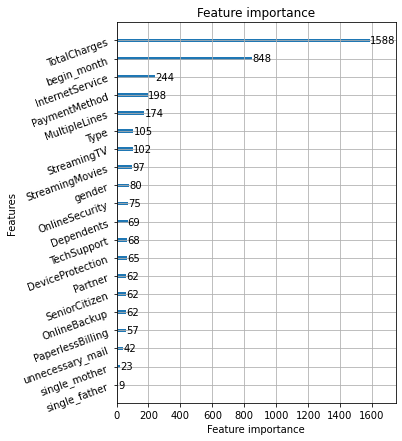

In [62]:
params = {
    'n_estimators': 65,
    'max_depth': 8,
    'num_leaves': 65,
    'learning_rate': 0.1435469272328213,
    'reg_alpha': 0.003208183290030983,
    'reg_lambda': 0.7390814771070586,
    'min_child_samples': 4
}

lgb_mod = lgb.LGBMClassifier(**params, random_state=80822)
lgb_mod.fit(train_features, train_target)
pred_valid = lgb_mod.predict_proba(valid_features)[:, 1]
roc_auc_valid = roc_auc_score(valid_target, pred_valid)
pred_test = lgb_mod.predict_proba(test_features)[:, 1]
roc_auc_test = roc_auc_score(test_target, pred_test)

print(f'roc_auc_score на валидационной выборке: {roc_auc_valid}\n')
print(f'roc_auc_score на тестовой выборке: {roc_auc_test}\n')


fig, ax = plt.subplots(figsize=(5, 7))
lgb.plot_importance(lgb_mod, ax=ax)
plt.yticks(rotation=20)
plt.show()

### Финальная модель: информация

<br>  
    
Модель: LGBMClassifier

<br>
    
Используемые признаки:

- ‘TotalCharges’
- ‘PaymentMethod’
- ‘InternetService’
- ‘MultipleLines’
- ‘Partner’
- ‘StreamingMovies’
- ‘StreamingTV’
- ‘gender’
- ‘OnlineSecurity’
- ‘OnlineBackup’
- ‘DeviceProtection’
- ‘Type’
- ‘TechSupport’
- ‘SeniorCitizen’
- ‘PaperlessBilling’
- ‘Dependents’
- ‘unnecessary_mail’
- ‘single_mother’
- ‘single_father’
- ‘begin_month’
    
    
Параметры: 
  
- n_estimators: 65
- max_depth: 8
- num_leaves: 65
- learning_rate: 0.1435469272328213
- reg_alpha: 0.003208183290030983
- reg_lambda: 0.7390814771070586
- min_child_samples: 4
    

    
Результаты:

- roc_auc_score на валидационной выборке: 0.89565

- roc_auc_score на тестовой выборке: 0.90915


# Итоги и выводы
<a id='итоги_и_выводы'></a>

[Содержание](#содержание)
    
<br>

В конце концов, удалось найти модель, у которой roc_auc_score выше 0.90.
    

<br>
    
Стоит отметить, что самые важные признаки для модели были 'TotalCharges' и 'begin_month'.
    
У 'TotalCharges' была высокая мультиколлинеарность, а также есть логическая связь (много платили, значит ещё не ушли). Этих два момента могут делать использование этого признака спорным. Однако, как выше отмечалось, мультиколлинеарность не всегда высказывается плохо на способность модели предсказывать. По поводу второго момента, я думаю, что стоит думать тут о вопросе лояльности клиента к компании. Этот фактор может оказать огромное влияние на выбор клиента о возможном росторжения контракта, и лояльность тесно связана с длительностью контракта, которая, в свою очередь, связана с общей суммой платежей. Чтобы устранить эту логическую проблему и таким образом улучшить модель, стоило бы думать о том, как оценить лояльность клиента. Другой способ решить проблему – использовать данные только с определённого периода времени (или разбить данные на группы по периоду времени); для такого подхода, наверное потребовалось бы большее количество данных.
    
<br>
    
Высокая важность 'begin_month' интересна тем, что это намекает на некую сезонность в данных (признак держит данные исключительно о месяце заключения контракта, не о годе). Чтобы больше разбираться в этом, возможно стоило бы рассмотреть данные BeginDate как datetime объекты, чтобы использовать возможности, например, библиотеки statsmodels.

    

    


</div>

# Часть 3

# Отчёт
<a id='отчёт'></a>

[Содержание](#содержание)

##### Рекомендуется читать отчёт в удобной для чтения форме по ссылке:

https://github.com/lanotebleue/telecom/blob/main/telecom_report.pdf

________


**1.	Введение**

Поставленной задачей была разработка модели для предсказывания ухода клиентов телекоммуникационной компании «Ниединогоразрыва.ком». Общая цель  исследования – помогать компании лучше понимать отток клиентов чтобы в будущем предотвратить уход клиента с помощью специальных предложений и тому подобного.

Несмотря на эту общую цель, задача заключалась в том, чтобы предсказать, уже ли ушёл клиент (а не уйдёт ли). Такое решение в постановке задачи возможно связано с количеством доступных данных.

Для выполнения задачи было предусмотрено несколько ключевых шагов.

1.	Обработка данных
2.	Создание новых признаков
3.	Сравнение разных моделей
4.	Улучшение итоговой модели


1.	Приведение данных в нужную модели форму. Главным образом это заключалось в том, чтобы изменить тип (dtype) данных.
2.	Конструирование новых признаков с информацией из исходных признаков. Например, использовать данные о наличии услуг стриминг ТВ и стриминг фильмов чтобы создать признак о пакете услуг стриминг.
3.	Тестирование разных моделей чтобы найти самую/ые обещающую/ие. Для этого шага модели применились с параметрами по умолчанию.
4.	Улучшение лучшей/их модели/ей. 

При исполнении проекта, все шаги были пройдены успешно и по порядку.

Важной частью проекта, не описанной в плане, являются проверка и выбор признаков. В этом шаге включались проверка корреляции признака с целевым признаком, проверка мультиколлинеарности признаков, а потом использование этой информации для принятия решения о том, какие признаки использовать. Это было сделано после создание новых признаков и до сравнения разных моделей. Таким образом, итоговый план работы получился таким:

1.	Обработка данных
2.	Создание новых признаков
3.	Проверка и выбор признаков
4.	Сравнение разных моделей
5.	Улучшение итоговой модели

<br>

**2.	Данные**

Данные были получены в четырёх разных .csv файлах, соответственно было создано четыре таблицы. Таблицы были удивительно цельными. Единственные найденные мной пропуски были в столбце с данными об общей сумме платежей (в таблице с данными о контрактах), а выяснилось, что все эти пропуски были у записей о новых контрактах. Иными словами, даже эти пропуски не были пропусками, а отсутствие платежей.
Нужно было переводить некоторые данные на новые типы. Были внесены следующие изменения:

- ‘BeginDate’ :
    o	dtype: str
    o	Было переведено на datetime а потом разбито на два отдельных признака с информацией о месяце и о годе заключения контракта.
- ‘EndDate’ :
    o	dtype: str
    o	Было переведено на булев тип (bool). В этом столбец было либо ‘No’, либо дата расторжения контракта, но для данного проекта важен только факт расторжения, а не дата.

Кроме этого, чтобы подготовить таблицу со всеми данными к использованию в модели, все категориальные признаки (т.е. все остальные признаки кроме ‘MonthlyCharges’ и ‘TotalCharges’), которые были типа str, были закодированными в числа. Например, в столбце с данными о типе контракта ‘Type’  –  ’Month-to-month’, ‘One year’, ‘Two year’ стали 0, 1, 2.

<br>

**3.	Создание признаков**

Были созданы следующие признаки:

- 'single_parent' : родитель-одиночка
- 'single_mother' : мать-одиночка
- 'single_father' : отец-одиночка
- 'unnecessary_mail' : этот признак показывает людей, которые платят электронно но всё равно получают квитанции по почте
- 'streaming_package' : этот признак показывает, когда у человека есть обе услуги стриминг (и фильмы, и телевидение)
- 'begin_year' : год заключения контракта
- 'begin_month' : месяц заключения контракта (не включая информацию о годе заключения)

Создание этих признаков было частью исследовательского процесса, в итоге не все были использованы для обучения модели.
Чтобы решить какие признаки (оригинальные и новые) использовать, были проведены проверки корреляции и мультиколлинеарности. На основе этой информации, было решено использовать следующие  признаки для обучения модели:

- ‘TotalCharges’
- ‘PaymentMethod’
- ‘InternetService’
- ‘MultipleLines’
- ‘Partner’
- ‘StreamingMovies’
- ‘StreamingTV’
- ‘gender’
- ‘OnlineSecurity’
- ‘OnlineBackup’
- ‘DeviceProtection’
- ‘Type’
- ‘TechSupport’
- ‘SeniorCitizen’
- ‘PaperlessBilling’
- ‘Dependents’
- ‘unnecessary_mail’
- ‘single_mother’
- ‘single_father’
- ‘begin_month’

Из этих признаков, самым спорным выбором является использование ‘TotalCharges’. Это спорный момент логически и по информации от проверки мультиколлинеарности, которая была высокая. Однако, мультиколлинеарность не обязательно высказывается плохо на способность модели предсказывать, что является целью этого проекта. По поводу логического момента, этот признак действительно может дать слишком много информации модели; то есть, если эти данные сильно влияют на модель, она может оказаться хуже при предсказывании ухода новых клиентов (у которых общая сумма платежей не может быть высокой), а это значительный недостаток. С другой стороны, стоит думать о вопросе лояльности клиента к компании. Этот фактор может оказать огромное влияние на выбор клиента о возможном расторжении контракта, и лояльность тесно связана с длительностью контракта, которая, в свою очередь, связана с общей суммой платежей. Из-за того, что мультиколлинеарность не будет влиять на достижение цели проекта, и из-за вопроса лояльности клиента, было решено оставить ‘TotalCharges’ в наборе признаков для тестирования модели.

<br>

**4.	Модели**

Тестирование моделей производилось со параметрами по умолчанию и проводилось несколько раз. Были протестированы следующие модели:

- LogisticRegression
- RidgeClassifier
- RandomForestClassifier
- ExtraTreesClassifier
- CatBoostClassifier
- LGBMClassifier
- XGBClassifier
- DummyClassifier

Была значительная разница между roc_auc_score результатами моделей, которые используют градиентный бустинг, и результатами моделей без бустнга; у группы с бустингом результаты были лучше.

Среди группы с бустнгом, у XGBClassifier и LGBMClassifier всегда был лучший результат. Однако, результаты всех трёх моделей – LGBMClassifier, XGBClassifier, и CatBoostClassifier – похожи; они чаще всего были около 0.77. 
После тестирования с параметрами по умолчанию, несколько раз  были тестированы лучшие модели (LGBM, XGB, CatBoost) с использованием Optuna для определения лучших параметров. Чаще всего получалось так, что у LGBMClassifier лучший результат на валидационной выборке, а у XGBClassifier лучший на тестовой выборке. Поэтому, ещё один раунд тестирования был проведён для этих моделей, опять используя Optuna но с бо́льшим количеством итераций.

После  очередного теста, оказалось, что лучший результат на тестовой выборке получился у модели LGMBClassifier, поэтому эта модель была выбрана как финальной.

<br>

**5.	Результаты**

Финальная модель: LGBMClassifier

Параметры:

- n_estimators:	65
- max_depth:	8
- num_leaves:	65
- learning_rate:	0.1435469272328213
- reg_alpha:	0.003208183290030983
- reg_lambda:	0.7390814771070586
- min_child_samples:	4

Результаты:

валидационная roc_auc_score:	0.89565

тестовая roc_auc_score:	   0.90915

Разные этапы проекта были важны для поиска лучшей модели. Качество финальной модели не зависло только от выбора начальной модели и параметров, но тоже зависло от выбора признаков.

Подробный список этапов следующий:

1.	Обработка данных
2.	Создание новых признаков
3.	Проверка и выбор признаков
4.	Сравнение разных моделей, используя все новые признаки
    a.	Параметры: по умолчанию
    b.	Лучшие: XGB, LGBM, CatBoost
5.	Улучшение итоговой модели
    a.	LGBM и XGB оба дали хорошие результаты, поэтому было использовано Optuna чтобы улучшить обе модели
    b.	В конце концов, LGBM выдал лучший результат
    
Вышеописанным образом был достигнут лучший результат.

<br>

**6.	Выводы и возможности для улучшений**

Удалось найти модель, у которой roc_auc_score выше 0.90.

Стоит отметить, что самые важные признаки для модели были 'TotalCharges' и 'begin_month'.

Как выше отмечалось, у 'TotalCharges' была высокая мультиколлинеарность, а также есть логическая связь между этим признаком и уходом/не уходом клиента. Для улучшения модели, было бы хорошо найти способ учесть лояльность клиента без использования ‘TotalCharges’. Например, компания Мегафон предоставляет и мобильную связь, и домашний интернет (среди других услуг). Если клиент долго использовал мобильные услуги компании, есть возможность что эта лояльность выскажется на его лояльность к услугам домашнего интернета.  Над вопросом оценки лояльности клиента нужно думать по больше, но это точно одно направление в поиске способов улучшить результат. 

Высокая важность 'begin_month' интересна тем, что это намекает на некую сезонность в данных (признак держит данные исключительно о месяце заключения контракта, не о годе). Чтобы больше разбираться в этом, возможно стоило бы рассмотреть данные BeginDate как datetime объекты, чтобы использовать возможности, например, библиотеки statsmodels.

Последнее, о чём стоит прокомментировать, это возникшие проблемы в проекте. Не было особых проблем как таковых. Данные были получены в хорошем состоянии, а трудные моменты на других этапах не возникали (во многом благодаря хорошему состоянию данных).
